In [18]:
import ast
import numpy as np
import matplotlib.colorbar as cb
import matplotlib.pyplot as plt
import pandas as pd

from numpy.polynomial.polynomial import polyfit
from scipy.optimize import curve_fit
from scipy.stats import pearsonr
from time import time

from constants import *

In [2]:
# evaluate list columns as lists instead of strings
def trylit(x):
    try:
        return ast.literal_eval(x)
    except:
        return x

rruff_db = pd.read_csv('data/rruff_db_tot_filtered.csv').map(trylit)

In [3]:
minerals_in_pgm = {}

for _, x in rruff_db.iterrows():
    mineral = x['mineral_name']
    
    try:
        pgms = x['pgm']
    except:
        continue

    if pgms is np.nan:
        continue
    
    for pgm in pgms:
        if pgm in minerals_in_pgm.keys():
            minerals_in_pgm[pgm].append(mineral)
        else:
            minerals_in_pgm[pgm] = [ mineral ]

In [4]:
pgm_attrs = pd.read_csv('data/2022_pgm_attributes.csv',
                        index_col='MODE'
                       ).transpose()
pgm_attrs.columns = [ s.lower() for s in pgm_attrs.columns ]

def get_attr(p, prop):
    if p[:-1] == 'p45':
        p = 'p45'
        
    if p[:-1] == 'p47':
        p = 'p47'
        
    return pgm_attrs[p][prop]


T_MIN = 'Temp (min) K'
T_MAX = 'Temp (max) K'
T_AVG = 'Temp (average) K'

P_MIN = 'P (min) log Pa'
P_MAX = 'P (max) log Pa'
P_AVG = 'P (average log Pa)'

In [5]:
def return_zero(p):
    if len(p) == 2:
        return f'{p[0]}0{p[1]}'
    return p

In [6]:
df = pd.read_csv('data/IMA_HM_loc_distribution_Feb2024.csv', index_col=0)

In [7]:
symmetry_indices = {
    'amorphous': 1,
    'triclinic': 2,
    'monoclinic': 4,
    'orthorhombic': 8,
    'trigonal': 12,
    'tetragonal': 16,
    'hexagonal': 24,
    'cubic': 48
}

sym_h = 0
num_h = 0
sym_a = 0
num_a = 0

for p in minerals_in_pgm.keys():    
    # for x in db.mineral_coll.find({ 'mineral_name': { '$in': minerals_in_pgm[p] } }):
    for _, x in rruff_db[rruff_db['mineral_name'].isin(minerals_in_pgm[p])].iterrows():
        for crystal_system in x['crystal_systems']:
            if crystal_system in symmetry_indices.keys():
                if 'H' in x['chemistry_elements']:
                    sym_h += symmetry_indices[crystal_system]
                    num_h += 1
                else:
                    sym_a += symmetry_indices[crystal_system]
                    num_a += 1

sym_h = sym_h / num_h / 48
sym_a = sym_a / num_a / 48
print(sym_h)
print(sym_a)

0.20414291530944625
0.3779499176082863


In [8]:
symmetry_indices = {
    1: 1,
    2: 2,
    3: 2,
    4: 2,
    5: 4,
    6: 4,
    7: 4,
    8: 8,
    9: 3,
    10: 6,
    11: 6,
    12: 6,
    13: 12,
    14: 6,
    15: 6,
    16: 12,
    17: 12,
    18: 12,
    19: 12,
    20: 24,
    21: 4,
    22: 4,
    23: 8,
    24: 8,
    25: 8,
    26: 8,
    27: 16,
    28: 12,
    29: 24,
    30: 24,
    31: 24,
    32: 48
}

In [10]:
time_start = time()
els = [ 'H', 'O', 'Al', 'Si', 'Ca', 'Fe', 'C', 'K', 'Mg' ]

pgm_symmetry_indices = {}
pgm_si_std = {}
pgm_el_pct = { el : {} for el in els }
pgm_loc_avg = {}
pgm_rare_pct = {}
pgm_populations = {}
n_minerals_in_pgm = {}

for p in minerals_in_pgm.keys():
    pgm_pop = { cs: 0 for cs in symmetry_indices.keys() }
    num_minerals = 0
    num_el_min = { el : 0 for el in els }
    pgm_sym_ind = []
    loc_num = 0
    rare_num = 0
    
    for _, x in rruff_db[rruff_db['mineral_name'].isin(minerals_in_pgm[p])].iterrows():
        try:
            df_min = df[df.name == x['mineral_name']]
            ln = df_min['Locality Num'].to_numpy()[0]
            cn = df_min['Class Nbr.'].to_numpy()[0]
        except:
            continue

        if cn == 0 or cn > 32:
            continue
                    
        loc_num += ln
        rare_num += int(ln < 5)
        pgm_pop[cn] += 1
        num_minerals += 1
        pgm_sym_ind.append(symmetry_indices[cn])
        for el in els:
            num_el_min[el] += int(el in x['chemistry_elements'])
            
    try:
        p = return_zero(p)
        # pgm_symmetry_indices[p] = pgm_sym_ind / max(symmetry_indices.values()) / num_minerals
        pgm_sym_ind = np.array(pgm_sym_ind) / max(symmetry_indices.values())
        pgm_symmetry_indices[p] = np.mean(pgm_sym_ind)
        pgm_si_std[p] = np.std(pgm_sym_ind)
        for el in els:
            pgm_el_pct[el][p] = num_el_min[el] / num_minerals

        pgm_loc_avg[p] = loc_num / num_minerals
        pgm_rare_pct[p] = rare_num / num_minerals
    except Exception as e:
        print(e)
        
    pgm_populations[p] = pgm_pop
    n_minerals_in_pgm[p] = num_minerals
    
pgm_symmetry_indices = { p: pgm_symmetry_indices[p] for p in sorted(pgm_symmetry_indices) }
pgm_si_std = { p: pgm_si_std[p] for p in sorted(pgm_symmetry_indices) }
for el in els:
    pgm_el_pct[el] = { p: pgm_el_pct[el][p] for p in sorted(pgm_symmetry_indices) }
pgm_loc_avg = { p: pgm_loc_avg[p] for p in sorted(pgm_symmetry_indices) }
pgm_rare_pct = { p: pgm_rare_pct[p] for p in sorted(pgm_symmetry_indices) }

print(f'Done in {time()-time_start:.2f}s')

Done in 3.47s


In [11]:
default_ordering = list(pgm_symmetry_indices.keys())[1:]

In [96]:
el_names = { 'H': 'hydrogen', 'O': 'oxygen', 'Al': 'aluminium', 'Si': 'silicon', 'Ca': 'calcium', 'Fe': 'iron', 'C': 'carbon', 'K': 'potassium', 'Mg': 'magnesium' }

def plot_el(el):
    no_p2 = [ p for p in default_ordering if p != 'p02' ]
    x_values = np.array([ pgm_el_pct[el][p] for p in no_p2 ])
    y_values = np.array([ pgm_symmetry_indices[p] for p in no_p2 ])
    y_err = np.array([ pgm_si_std[p] for p in no_p2 ])
    
    # Calculate Pearson correlation coefficient
    correlation_coefficient, p_value = pearsonr(x_values, y_values)
    
    # Create the scatter plot
    plt.figure(figsize=(8, 6))  # Adjust the figure size if needed
    plt.errorbar(x_values, y_values, yerr=y_err, fmt='o', color='blue', alpha=0.8, label='Data')  # Adjust color and transparency as needed
    
    # Plot the best fit line
    # m, b = np.polyfit(x_values, y_values, 1)
    (m, b), cov = curve_fit(lambda x, m, b: m*x + b, x_values, y_values, p0=(0, 0.5), sigma=y_err, absolute_sigma=True)
    dm, db = np.sqrt(cov[0][0]), np.sqrt(cov[1][1])
    # (m, b), cov = curve_fit(lambda x, m, b: m*x + b, x_values, y_values, p0=(0, 0.5))
    print(f'm = {m:.3f} pm {dm:.3f}')
    print(f'b = {b:.3f} pm {db:.3f}')
    
    y_fit = m*x_values + b
    plt.plot(x_values, y_fit, color='red', alpha=0.7, label=f'Best Fit Line (Correlation: {correlation_coefficient:.2f})')
    # plt.plot(x_values, (m+dm)*x_values + b, ls='--', c='hotpink')
    # plt.plot(x_values, (m-dm)*x_values + b, ls='--', c='hotpink')
    # plt.plot(x_values, m*x_values + b + db, ls='--', c='purple')
    # plt.plot(x_values, m*x_values + b - db, ls='--', c='purple')
    plt.xlabel(f'Percent of minerals containing {el_names[el]}', fontsize=16)
    plt.ylabel('Symmetry Index', fontsize=16)
    plt.grid(True, alpha=0.2)  # Add gridlines if needed
    plt.legend()

    # find the 95% confidence intervals
    # rss = np.sum((y_values - y_fit)**2/y_err**2)
    # rss = np.sum((y_values - y_fit)**2)
    ## test-values for x, and predicted y
    p_x = np.linspace(np.min(x_values), np.max(x_values), 100)
    p_y = m*p_x + b
    ## confidence interval
    mean_x = np.mean(x_values)
    n_x = len(x_values)
    t = 1.997 # appropriate t-value (n=65, 95%)
    # confs = t * np.sqrt((rss/(n_x-2))*(1./n_x + (p_x-mean_x)**2/(np.sum(x_values**2) - n_x * mean_x**2)))
    # confs = t * rss * np.sqrt((p_x - mean_x)**2/np.sum(x_values**2) + 1/n_x)
    # confs2 = t * rss * np.sqrt((p_x - mean_x)**2/np.sum(x_values**2) + 1/n_x + 1)
    
    vars = cov[0][0] + cov[1][1] * p_x**2 + 2*p_x * cov[0][1]
    confs = np.abs(t * np.sqrt(vars))

    # rss = np.sum((y_values - y_fit)**2)
    # syx = np.sqrt(rss/(n_x-2))
    # confs = syx * np.sqrt(1/n_x + (p_x - mean_x)**2/np.sum((x_values - mean_x)**2))
    
    plt.plot(p_x, p_y - confs, 'g--')
    plt.plot(p_x, p_y + confs, 'g--')
    # plt.plot(p_x, p_y - np.abs(confs2), 'g--')
    # plt.plot(p_x, p_y + np.abs(confs2), 'g--')
    
    # Adjust the font size for the numbers on the x and y axes
    plt.tick_params(axis='both', which='major', labelsize=12)

    plt.xlim(-0.02, 1.02)
    plt.ylim(0, 0.8)
    
    plt.savefig(f"results/SI_vs_{el}.png", dpi=300)
    plt.show()

m = -0.203 pm 0.072
b = 0.282 pm 0.056


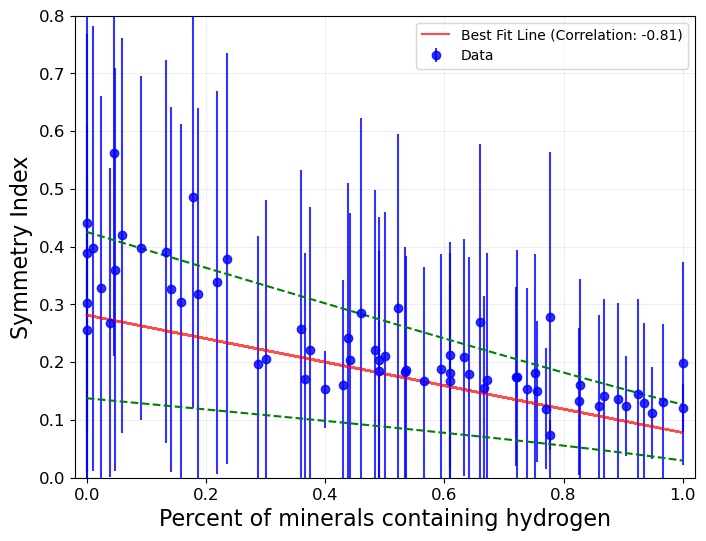

In [97]:
plot_el('H')

m = -0.203 pm 0.072
b = 0.282 pm 0.056


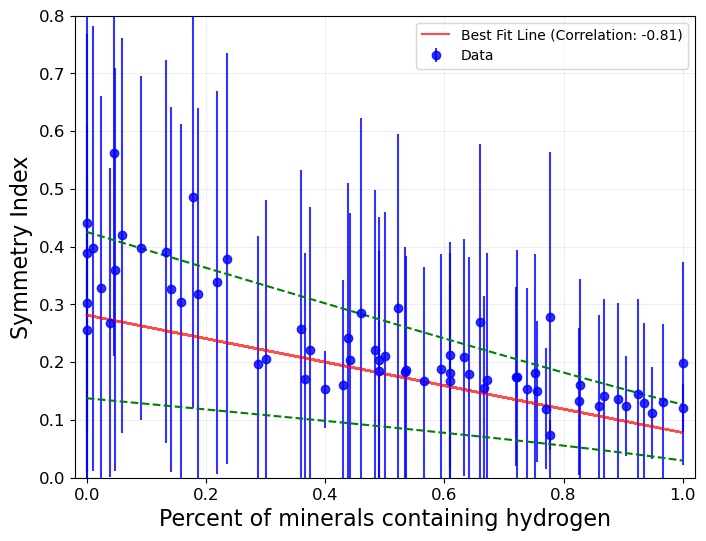

m = -0.381 pm 0.121
b = 0.495 pm 0.117


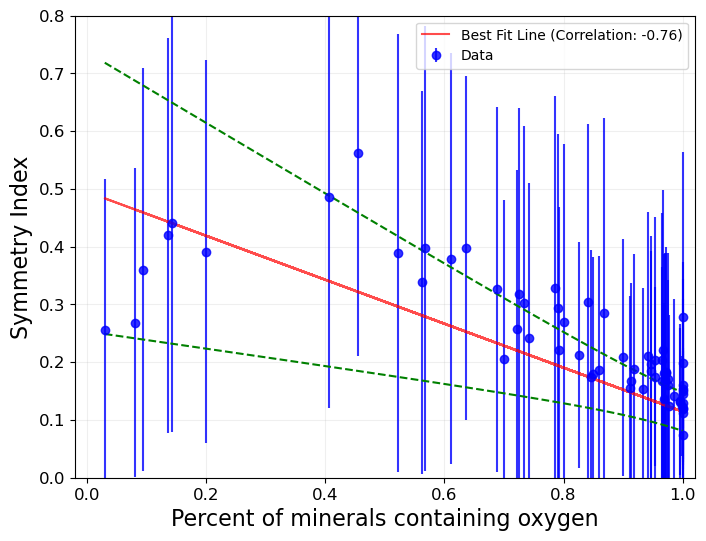

m = -0.103 pm 0.049
b = 0.172 pm 0.026


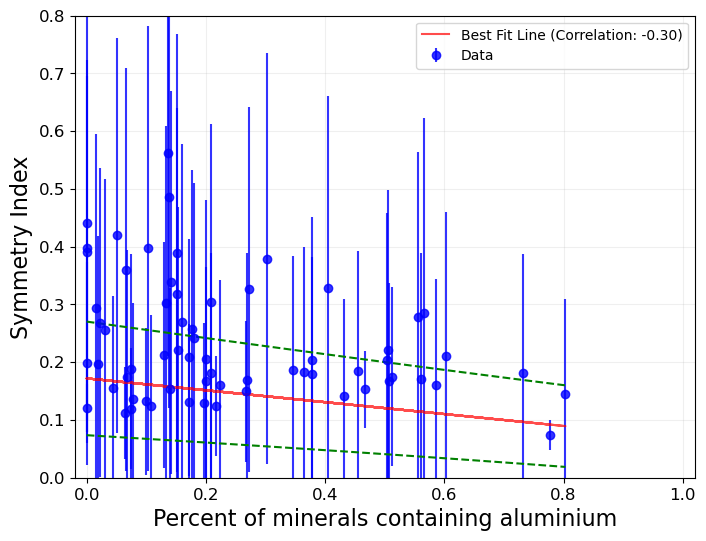

m = -0.083 pm 0.043
b = 0.169 pm 0.026


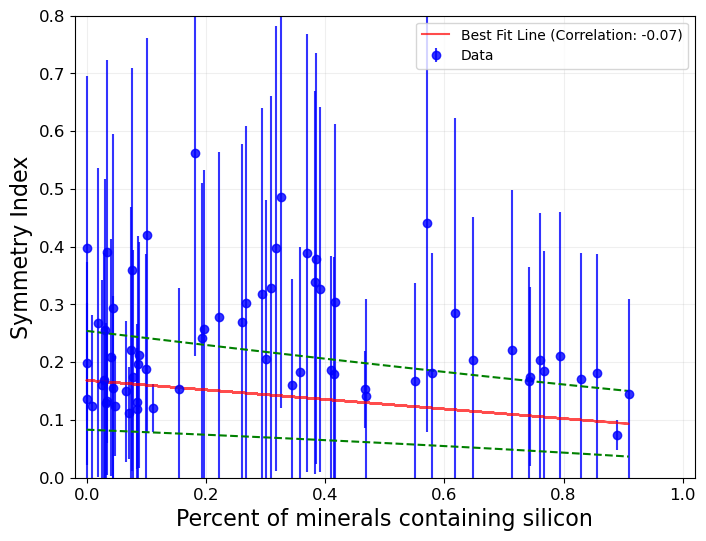

m = 0.042 pm 0.176
b = 0.120 pm 0.042


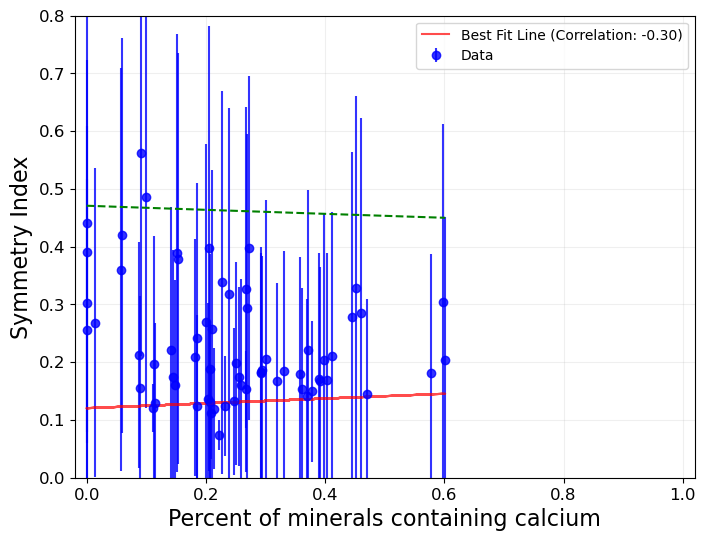

m = 0.289 pm 0.143
b = 0.088 pm 0.026


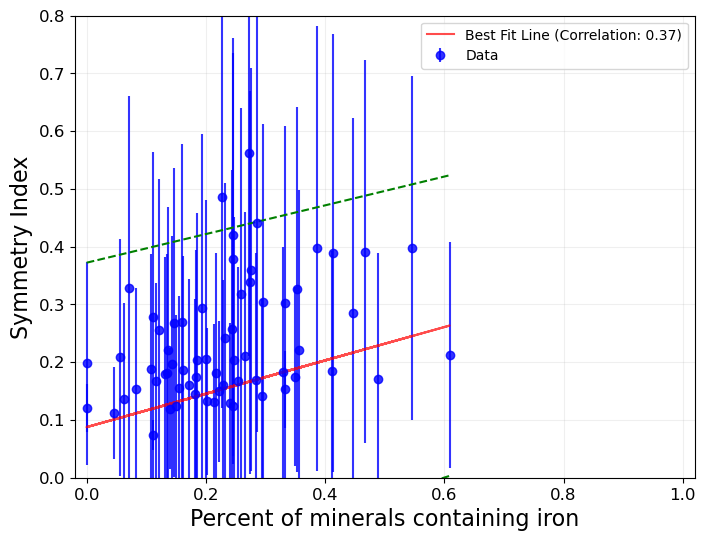

m = 0.287 pm 0.182
b = 0.116 pm 0.018


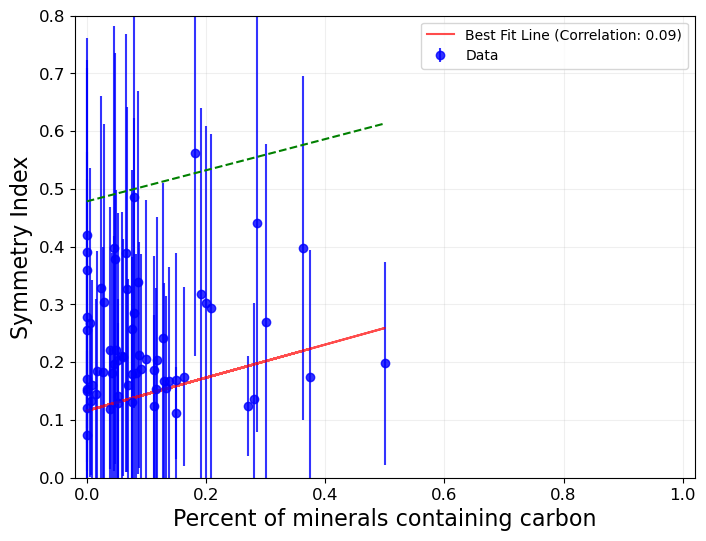

m = -0.205 pm 0.246
b = 0.155 pm 0.034


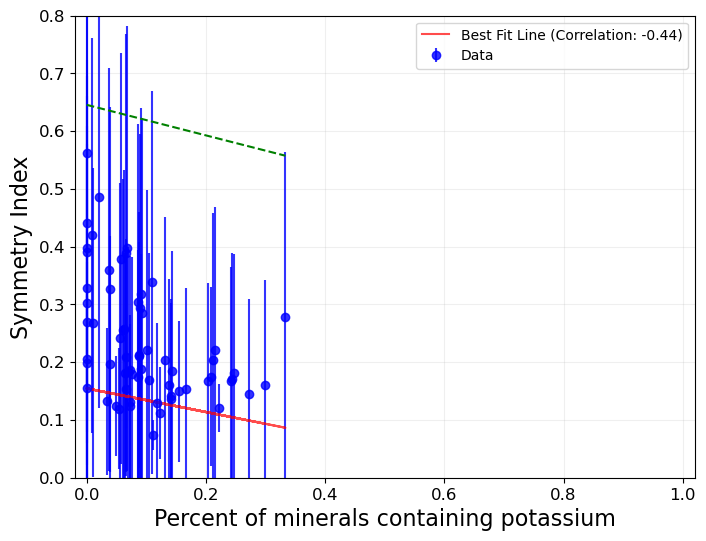

m = 0.210 pm 0.181
b = 0.104 pm 0.027


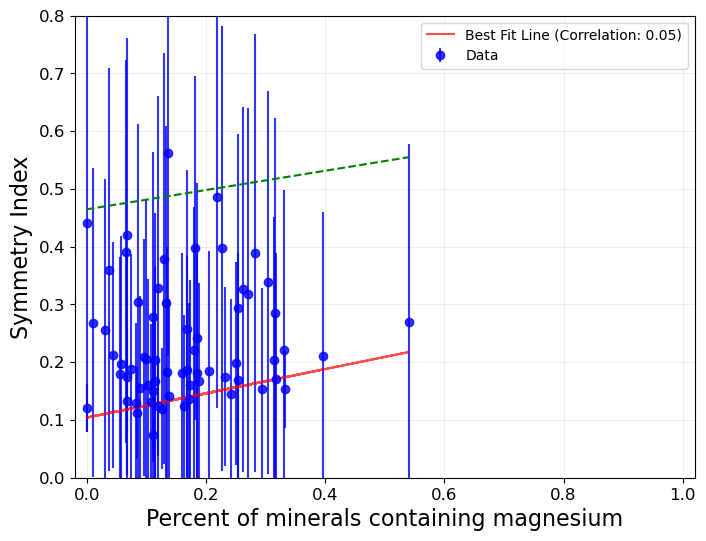

In [98]:
for el in els:
    plot_el(el)

m = -0.257 pm 0.079
b = 0.293 pm 0.022


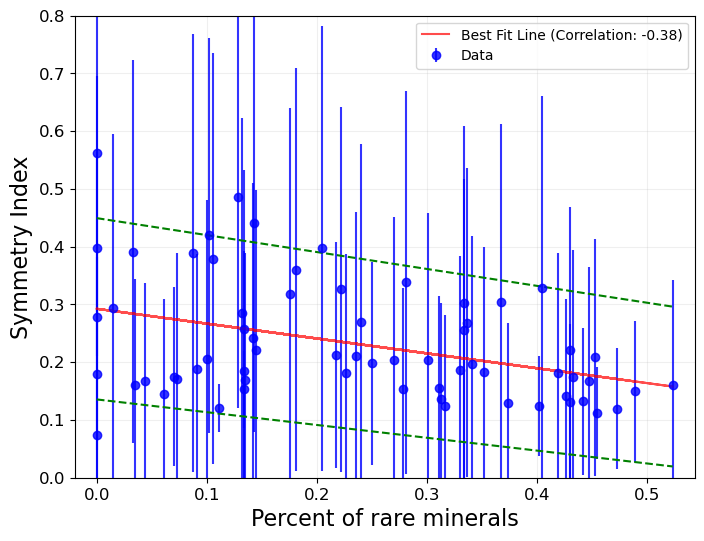

In [102]:
no_p2 = [ p for p in default_ordering if p != 'p02' ]
x_values = np.array([ pgm_rare_pct[p] for p in no_p2 ])
y_values = np.array([ pgm_symmetry_indices[p] for p in no_p2 ])
y_err = np.array([ pgm_si_std[p] for p in no_p2 ])

# Calculate Pearson correlation coefficient
correlation_coefficient, p_value = pearsonr(x_values, y_values)

# Create the scatter plot
plt.figure(figsize=(8, 6))  # Adjust the figure size if needed
plt.errorbar(x_values, y_values, yerr=y_err, fmt='o', color='blue', alpha=0.8, label='Data')  # Adjust color and transparency as needed

# Plot the best fit line
# m, b = np.polyfit(x_values, y_values, 1)
# (m, b), cov = curve_fit(lambda x, m, b: m*x + b, x_values, y_values, p0=(0, 0.5), sigma=y_err, absolute_sigma=True)
(m, b), cov = curve_fit(lambda x, m, b: m*x + b, x_values, y_values, p0=(0, 0.5))
dm, db = np.sqrt(cov[0][0]), np.sqrt(cov[1][1])
# (m, b), cov = curve_fit(lambda x, m, b: m*x + b, x_values, y_values, p0=(0, 0.5))
print(f'm = {m:.3f} pm {dm:.3f}')
print(f'b = {b:.3f} pm {db:.3f}')

y_fit = m*x_values + b
plt.plot(x_values, y_fit, color='red', alpha=0.7, label=f'Best Fit Line (Correlation: {correlation_coefficient:.2f})')
# plt.plot(x_values, (m+dm)*x_values + b, ls='--', c='hotpink')
# plt.plot(x_values, (m-dm)*x_values + b, ls='--', c='hotpink')
# plt.plot(x_values, m*x_values + b + db, ls='--', c='purple')
# plt.plot(x_values, m*x_values + b - db, ls='--', c='purple')
plt.xlabel(f'Percent of rare minerals', fontsize=16)
plt.ylabel('Symmetry Index', fontsize=16)
plt.grid(True, alpha=0.2)  # Add gridlines if needed
plt.legend()

# find the 95% confidence intervals
# rss = np.sum((y_values - y_fit)**2/y_err**2)
# rss = np.sum((y_values - y_fit)**2)
## test-values for x, and predicted y
p_x = np.linspace(np.min(x_values), np.max(x_values), 100)
p_y = m*p_x + b
## confidence interval
mean_x = np.mean(x_values)
n_x = len(x_values)
t = 1.997 # appropriate t-value (n=65, 95%)
# confs = t * np.sqrt((rss/(n_x-2))*(1./n_x + (p_x-mean_x)**2/(np.sum(x_values**2) - n_x * mean_x**2)))
# confs = t * rss * np.sqrt((p_x - mean_x)**2/np.sum(x_values**2) + 1/n_x)
# confs2 = t * rss * np.sqrt((p_x - mean_x)**2/np.sum(x_values**2) + 1/n_x + 1)

vars = cov[0][0] + cov[1][1] * p_x**2 + 2*p_x * cov[0][1]
confs = np.abs(t * np.sqrt(vars))

# rss = np.sum((y_values - y_fit)**2)
# syx = np.sqrt(rss/(n_x-2))
# confs = syx * np.sqrt(1/n_x + (p_x - mean_x)**2/np.sum((x_values - mean_x)**2))

plt.plot(p_x, p_y - confs, 'g--')
plt.plot(p_x, p_y + confs, 'g--')
# plt.plot(p_x, p_y - np.abs(confs2), 'g--')
# plt.plot(p_x, p_y + np.abs(confs2), 'g--')

# Adjust the font size for the numbers on the x and y axes
plt.tick_params(axis='both', which='major', labelsize=12)

plt.xlim(-0.02, max(x_values)+0.02)
plt.ylim(0, 0.8)

plt.savefig(f"results/SI_vs_{el}.png", dpi=300)
plt.show()

In [33]:
def order(x):
    return [ x[p] for p in default_ordering ]

d = {
    'n_minerals': order(n_minerals_in_pgm),
    'symmetry_index': order(pgm_symmetry_indices),
    'h_to_all_ratio': order(pgm_el_pct['H']),
    'avg_num_loc': order(pgm_loc_avg),
    'rare_to_all_ratio': order(pgm_rare_pct)
}

pd.DataFrame(data=d, index=default_ordering).to_csv('results/results.csv')

In [63]:
cmap = plt.get_cmap('PuOr')

def plot_pgm(ordering, name, n_plots=3, nums=False, loc_avg=True):
    fig, ax = plt.subplots(n_plots, figsize=(15*3/n_plots, 10*n_plots))
    l = len(ordering)//n_plots
    y_lim_upper = max([ pgm_symmetry_indices[p] for p in ordering ]) * 1.05

    locm = pgm_loc_avg if loc_avg else pgm_rare_pct
    loc_str = "and average number of localities" if loc_avg else "and fraction of rare mineral species"
    twin_lim_upper = max([ locm[p] for p in ordering ]) * 1.05
    
    if n_plots == 1:
        ax = [ax]
        
    if len(ordering) % n_plots != 0:
        l += 1

    for i in range(n_plots):
        s, e = i*l, (i+1)*l
        num_name = f' ({(i+1)}/{n_plots})' if n_plots > 1 else ''

        r = len(ordering[s:e])
        bars = ax[i].bar(range(r), [ pgm_symmetry_indices[p] for p in ordering[s:e] ],
                         color=cmap([ pgm_el_pct['H'][p] for p in ordering[s:e] ]))
        ax[i].set_xticks(range(r), labels=ordering[s:e])
        ax[i].tick_params(axis='both', labelsize=FS_TICK)
        ax[i].set_title(f'Symmetry index {loc_str} of different paragenetic modes{num_name}', fontsize=FS_TITLE)
        ax[i].set_ylim(0, y_lim_upper)

        twin = ax[i].twinx()
        twin.plot(range(r), [ locm[p] for p in ordering[s:e] ],
                  c='limegreen', lw=4)
        twin.plot(range(r), [ locm[p] for p in ordering[s:e] ],
                  c='green', lw=0, marker='o', markersize=12)
        twin.tick_params(axis='both', labelsize=FS_TICK)
        twin.set_ylim(0, twin_lim_upper)


    # [ print(f'{p}:\t {sym:.3f}') for p, sym in pgm_symmetry_indices.items() ]

        if nums:
            for n_minerals, bar in zip([ n_minerals_in_pgm[p] for p in ordering[s:e] ], bars):
                ax[i].text(bar.get_x() + bar.get_width()/2, bar.get_height(),
                           f'{n_minerals}',
                           ha='center', va='bottom', fontsize=FS_SAMPLE
                          )
    ax2 = fig.add_axes([0.915, 0.1, 0.02, 0.8])
    cb.Colorbar(ax=ax2, cmap=cmap)
    ax2.tick_params(labelsize=FS_TICK)

    plt.savefig(f'results/{name}.png', dpi=300*3/n_plots, bbox_inches='tight')
    
default_ordering = list(pgm_symmetry_indices.keys())[1:]

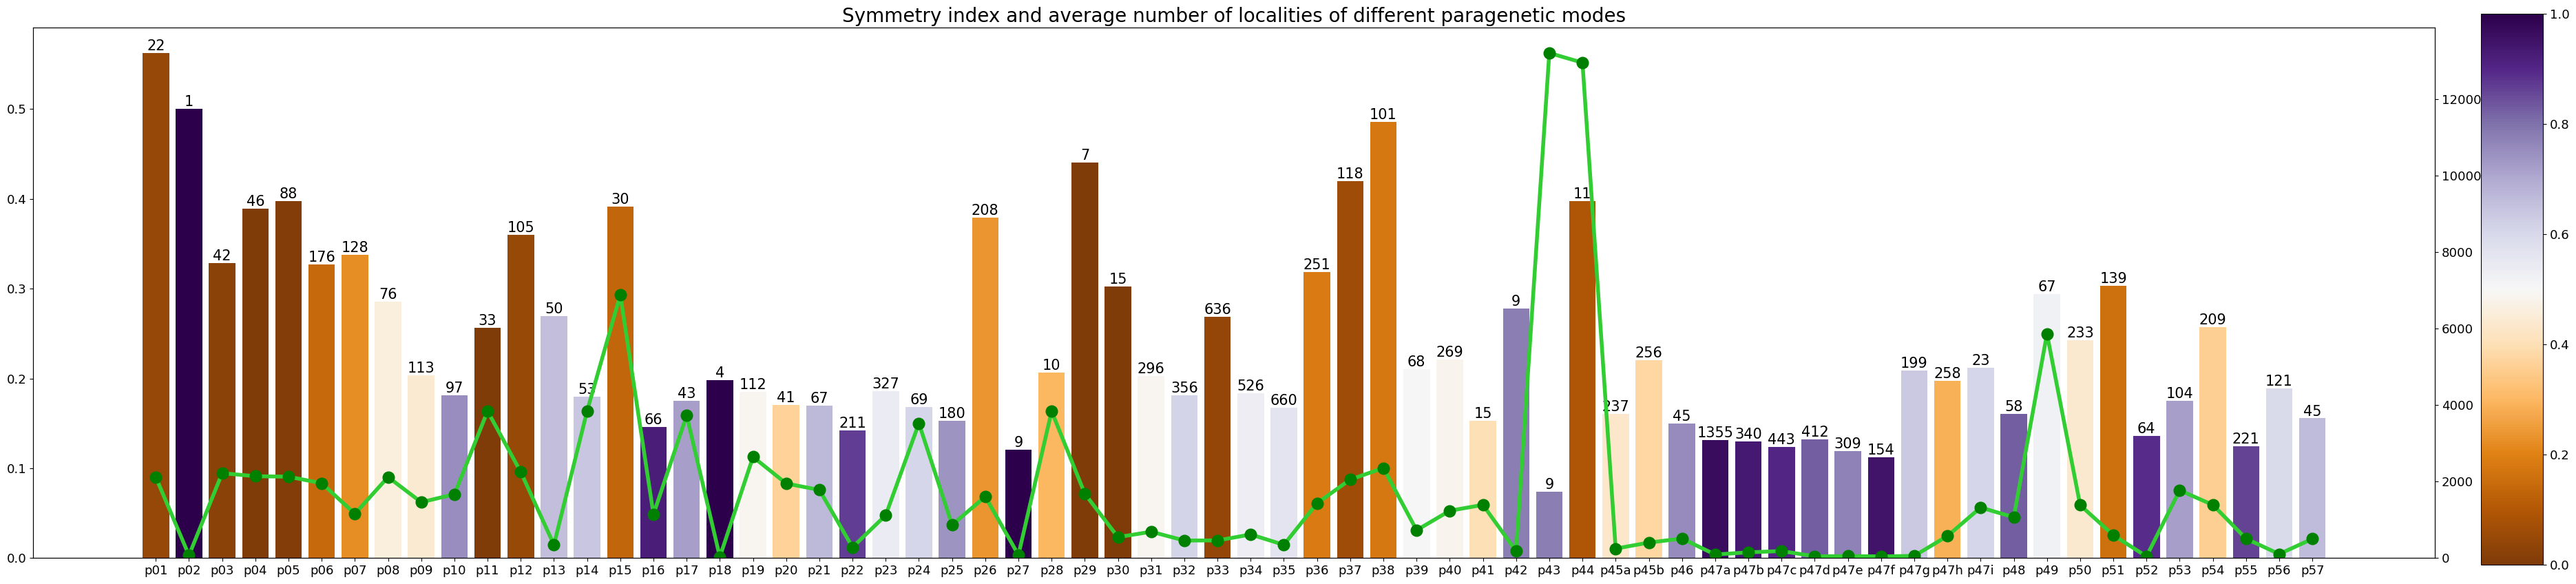

In [64]:
plot_pgm(default_ordering, 'graph_pgm_loc', n_plots=1, nums=True)

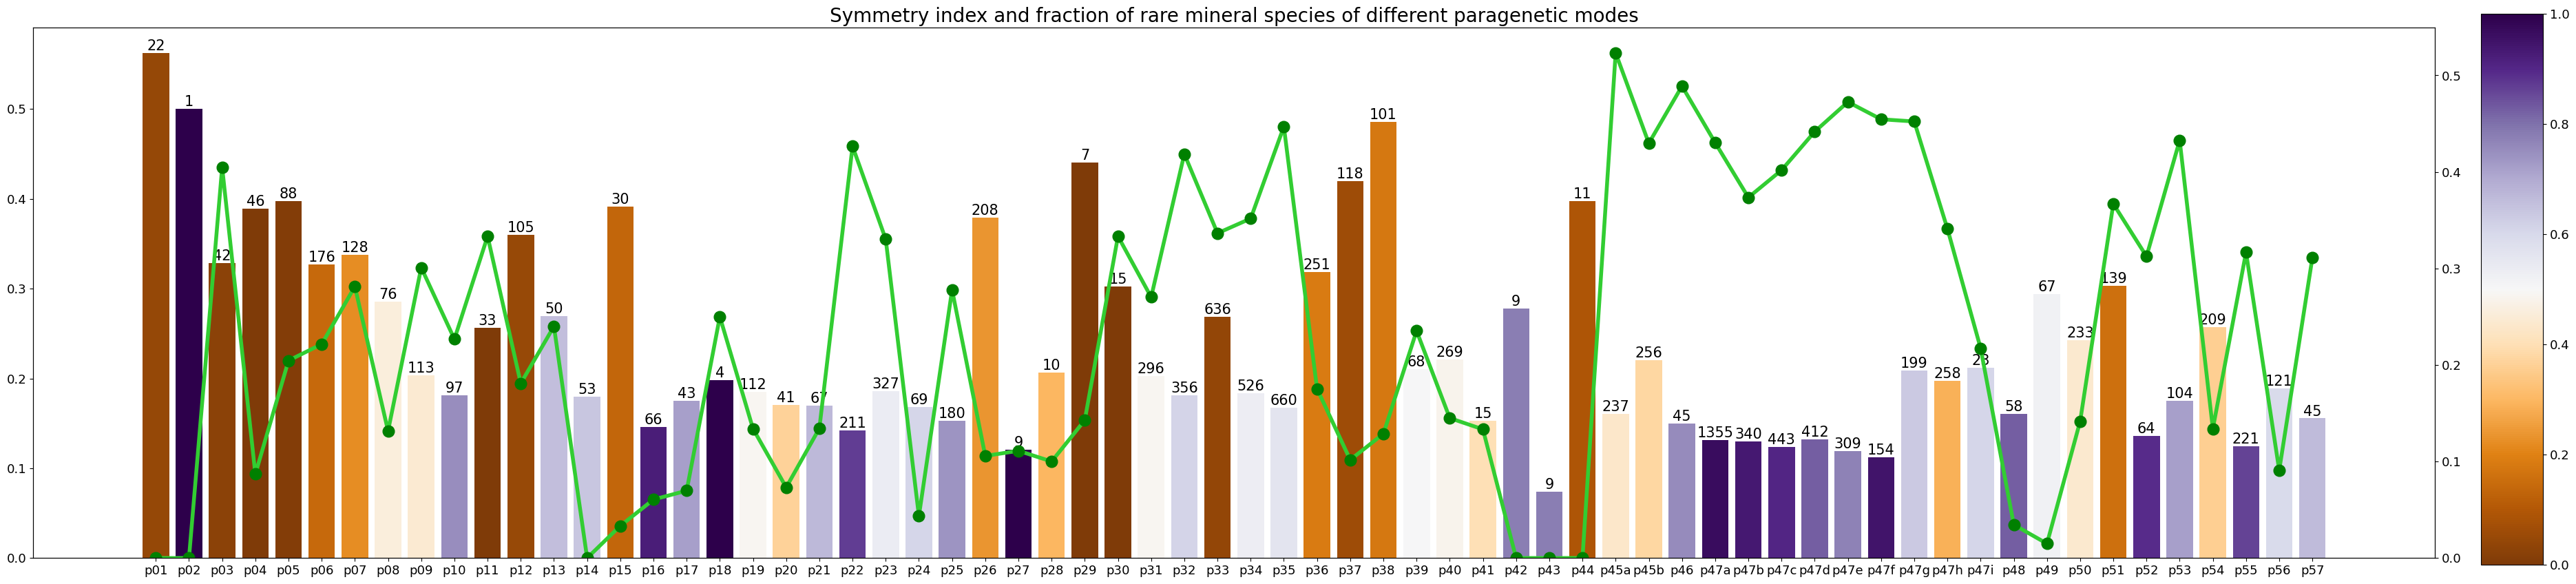

In [65]:
plot_pgm(default_ordering, 'graph_pgm_rare', n_plots=1, nums=True, loc_avg=False)

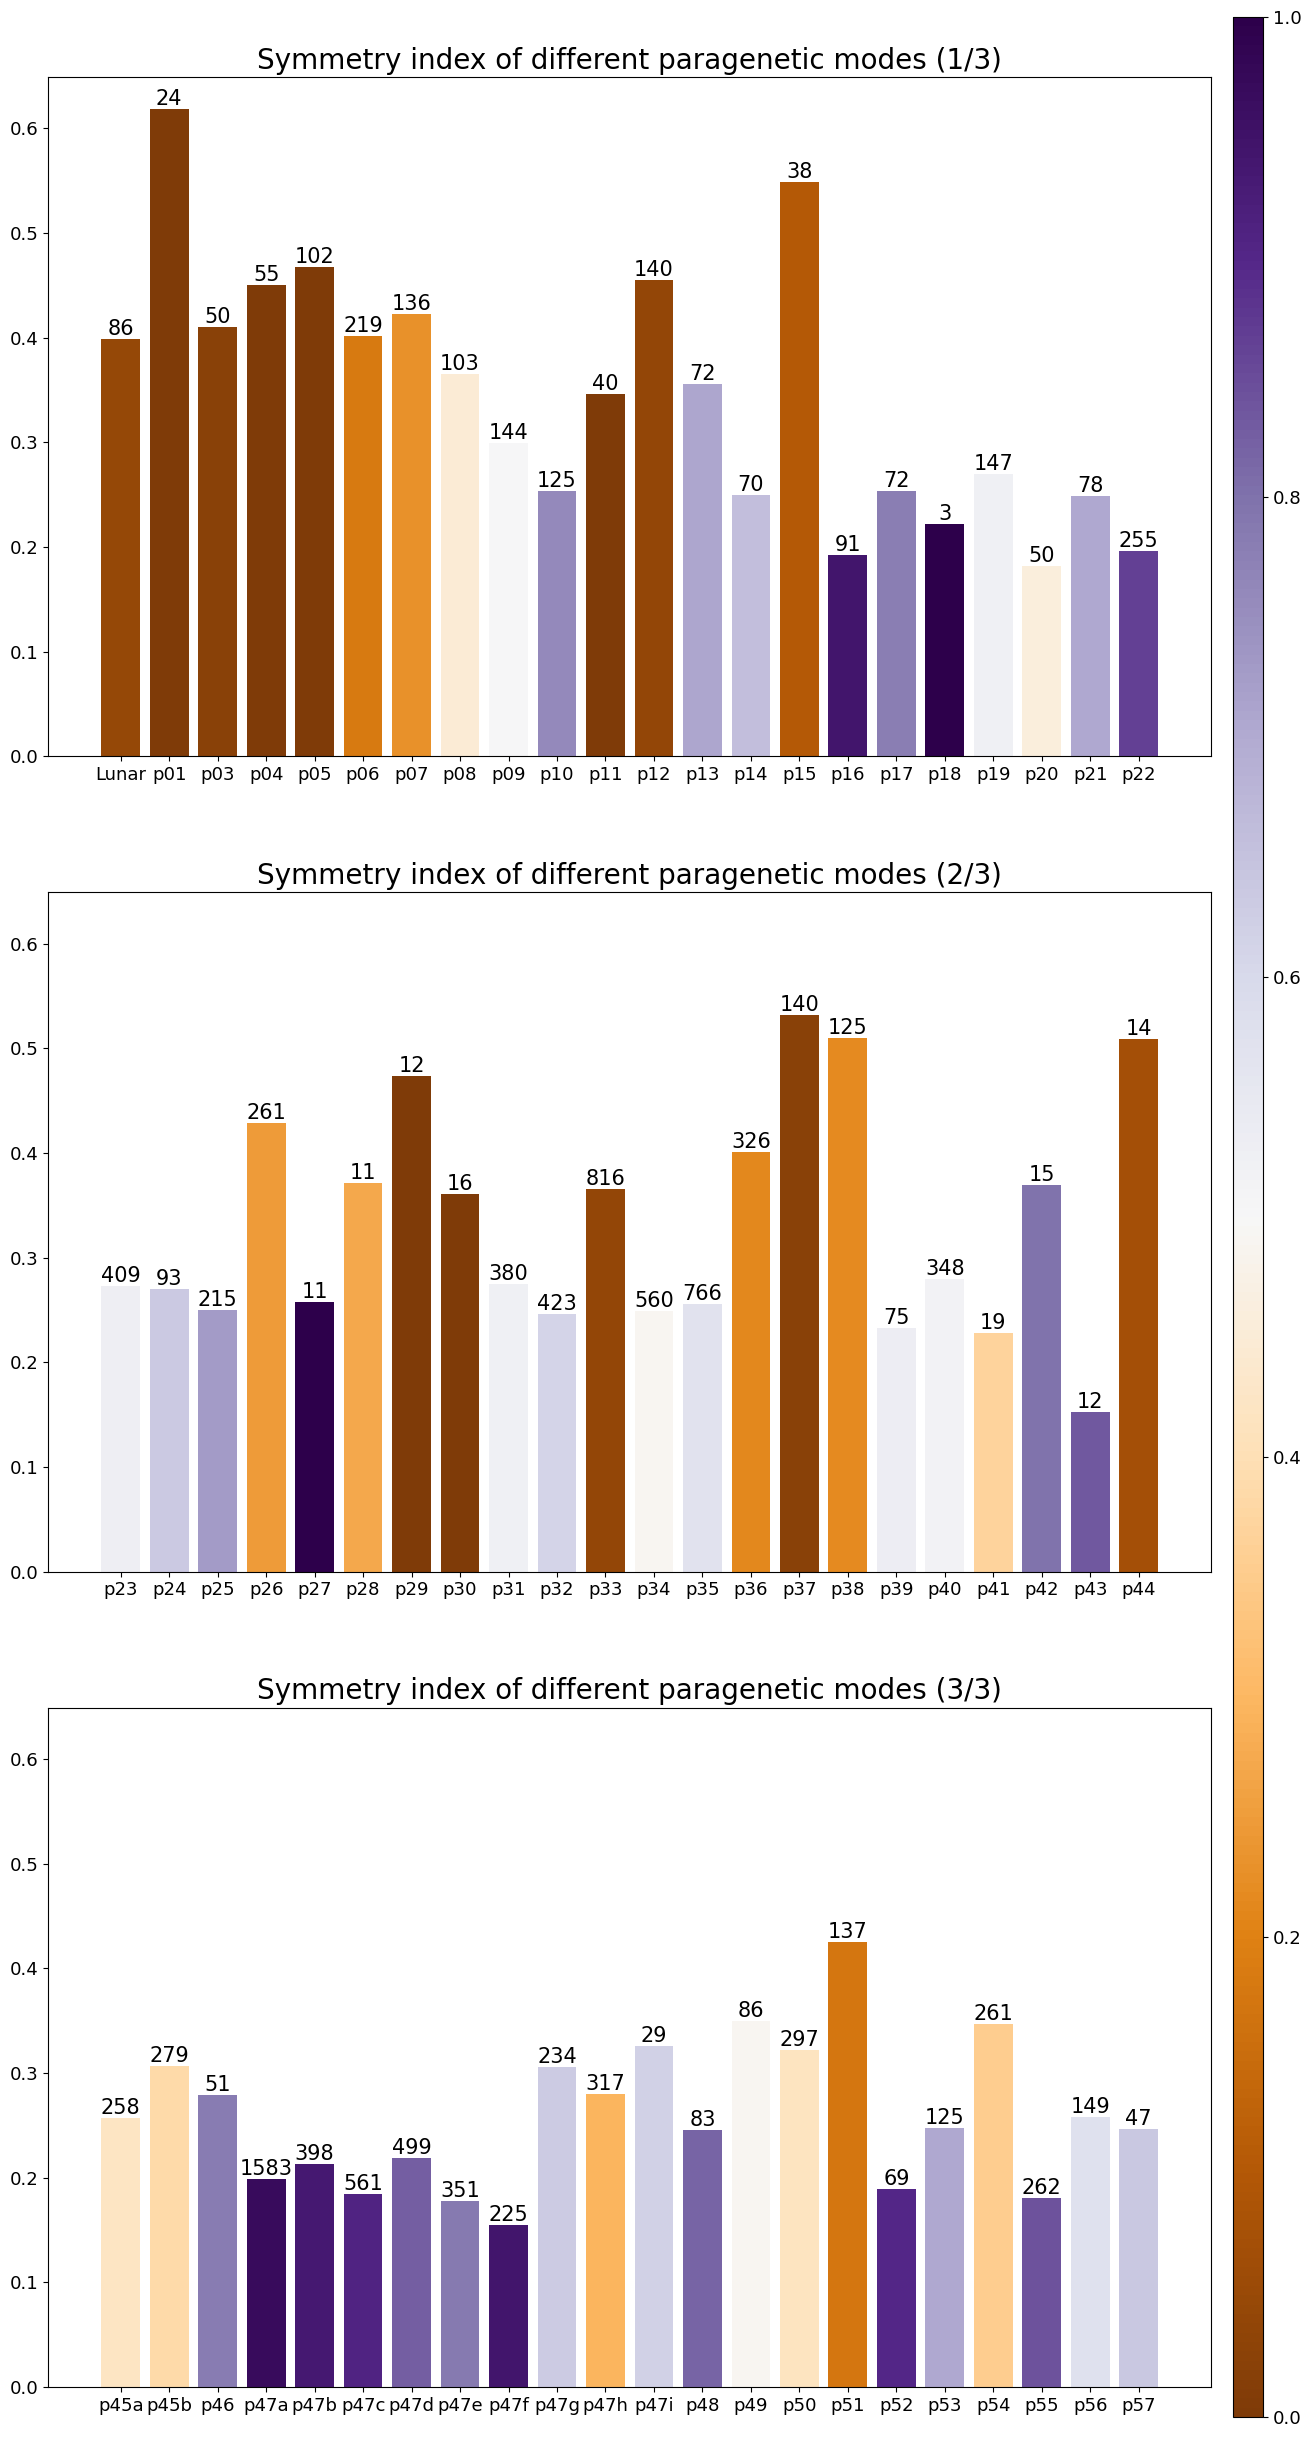

In [79]:
plot_pgm(['Lunar'] + default_ordering, 'graph_pgm', nums=True)

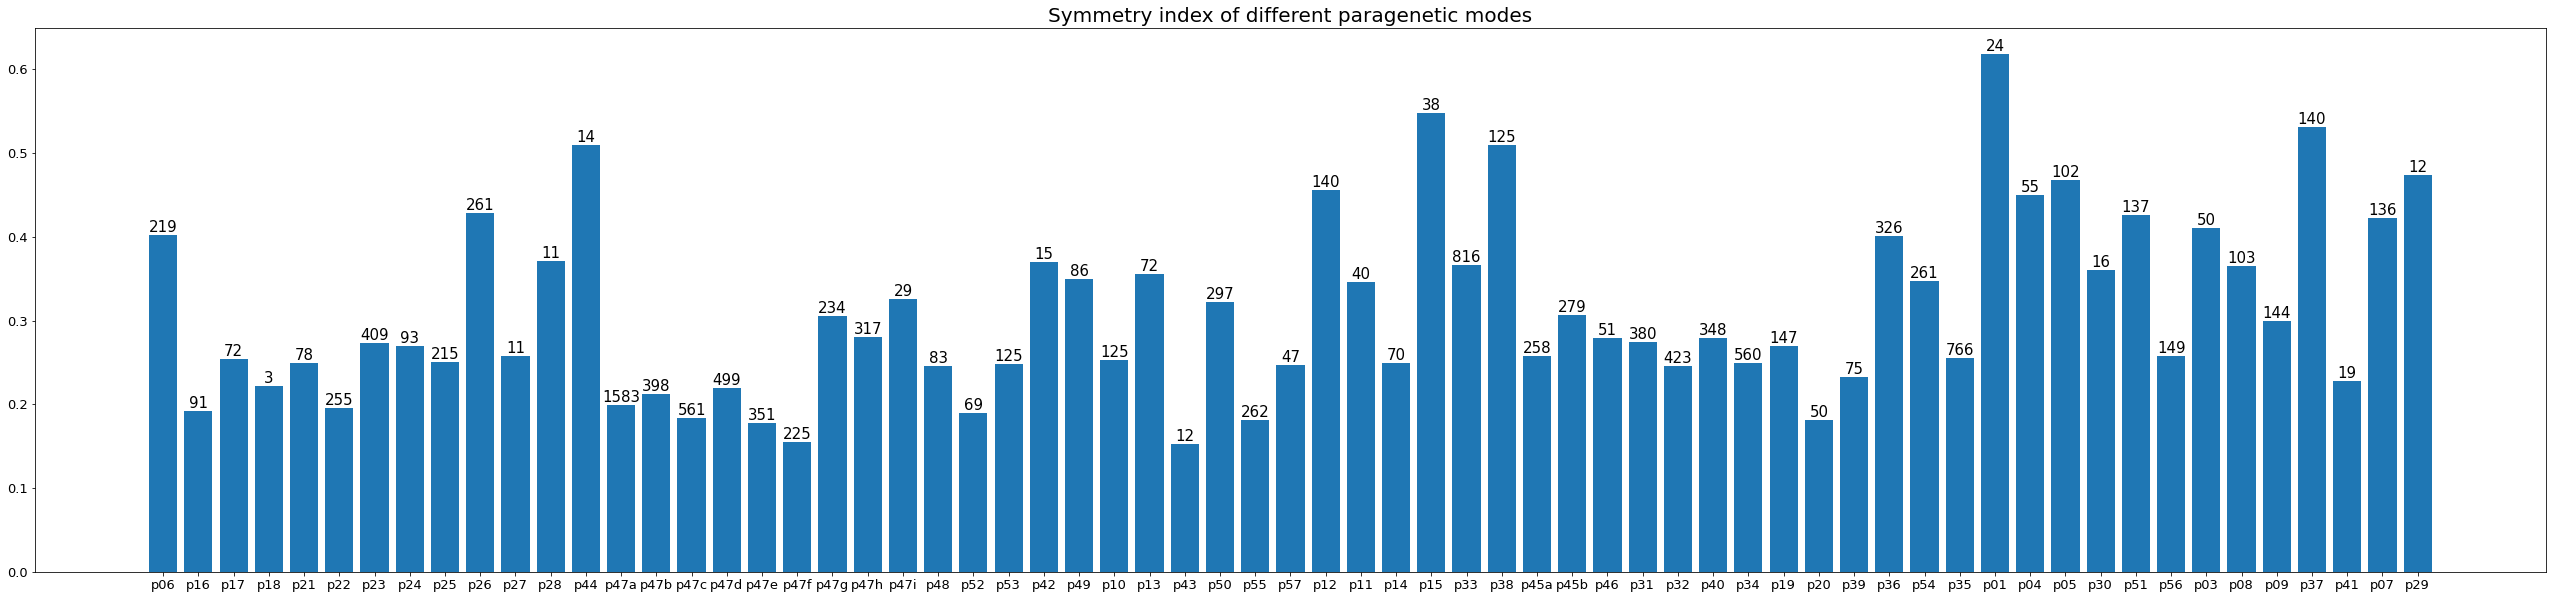

In [42]:
t_min_ordering = sorted(default_ordering, key=lambda p: get_attr(p, T_MIN))
plot_pgm(t_min_ordering, 'graph_pgm_tmin_1', n_plots=1, nums=True)

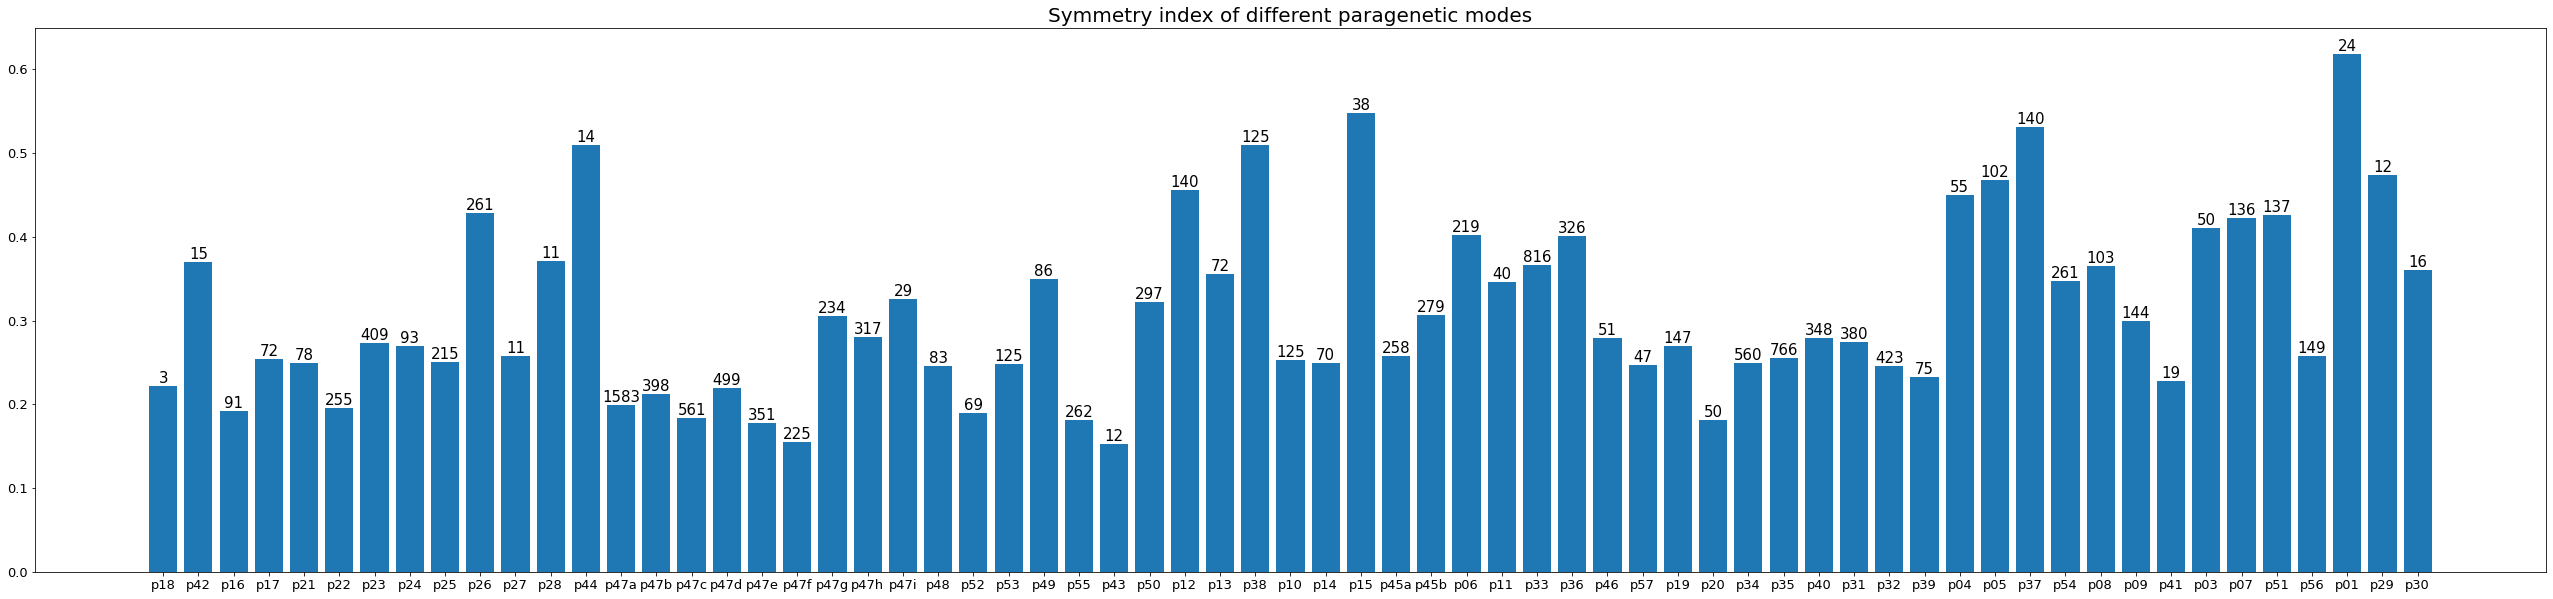

In [43]:
t_max_ordering = sorted(default_ordering, key=lambda p: get_attr(p, T_MAX))
plot_pgm(t_max_ordering, 'graph_pgm_tmax_1', n_plots=1, nums=True)

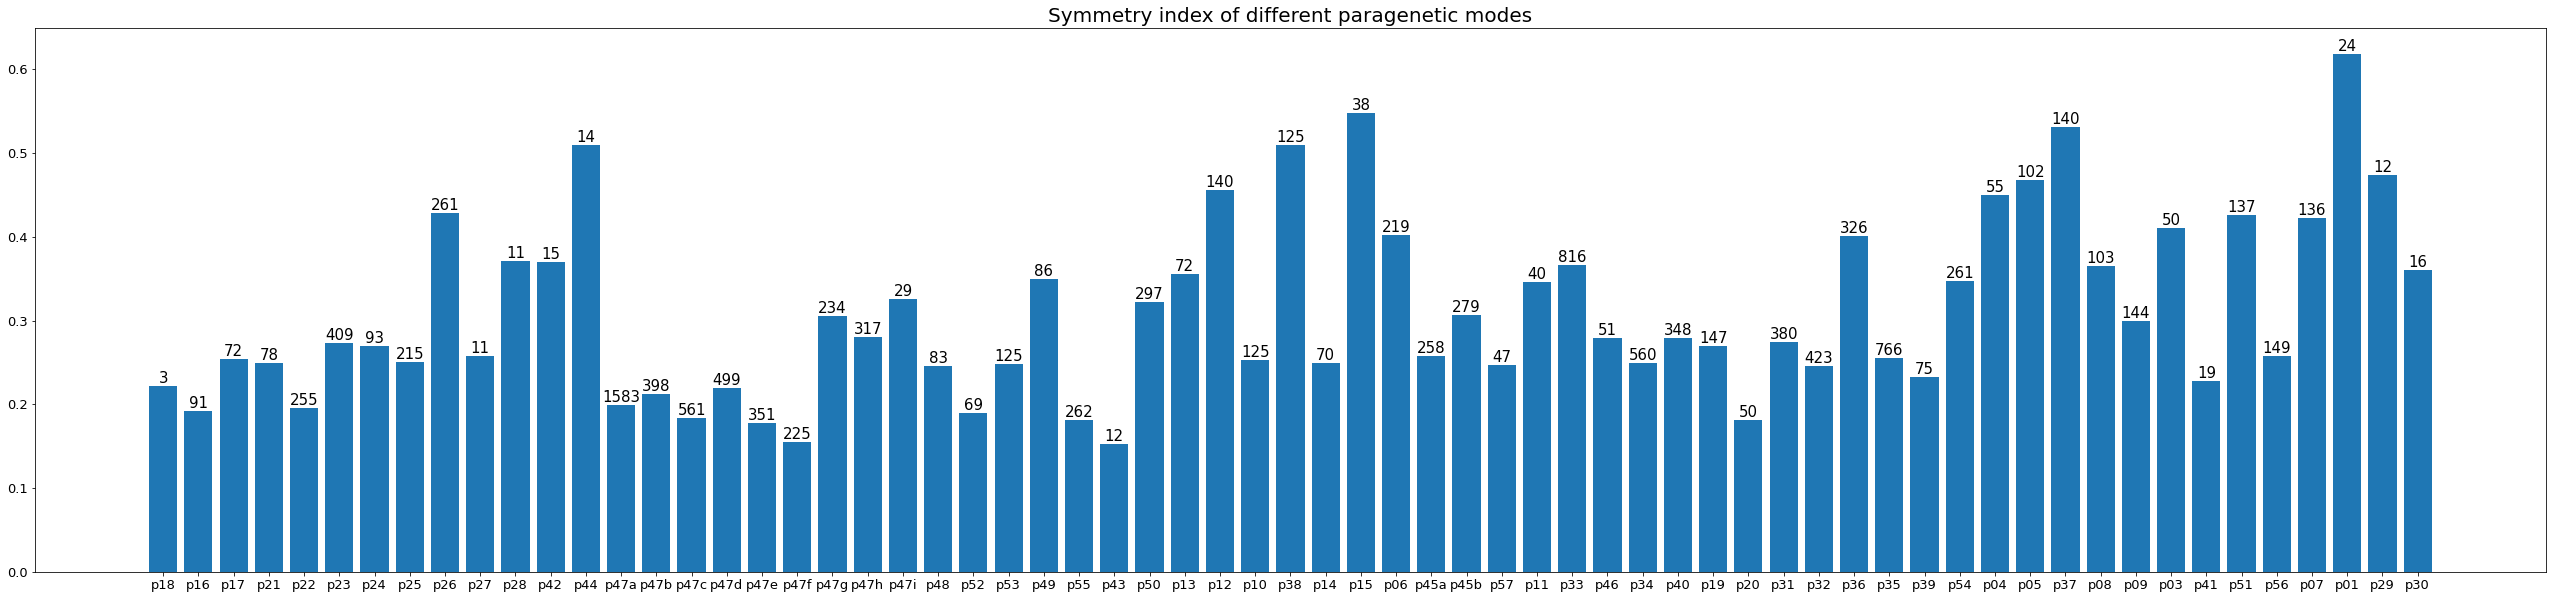

In [44]:
t_avg_ordering = sorted(default_ordering, key=lambda p: get_attr(p, T_AVG))
plot_pgm(t_avg_ordering, 'graph_pgm_tavg_1', n_plots=1, nums=True)

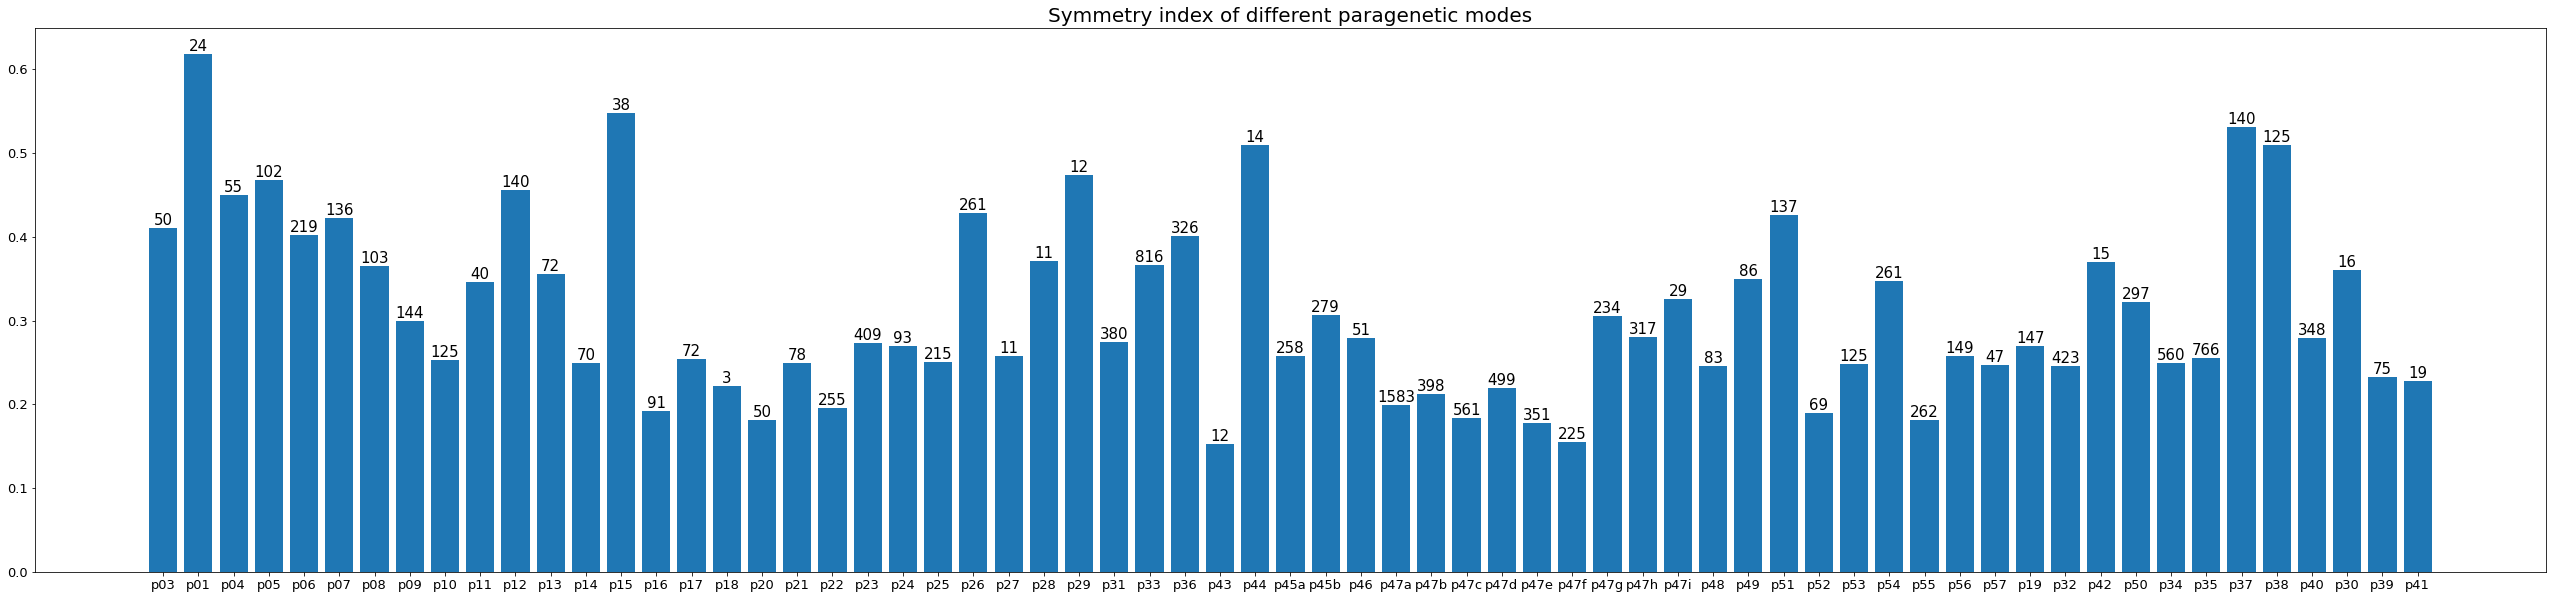

In [45]:
p_min_ordering = sorted(default_ordering, key=lambda p: get_attr(p, P_MIN))
plot_pgm(p_min_ordering, 'graph_pgm_pmin_1', n_plots=1, nums=True)

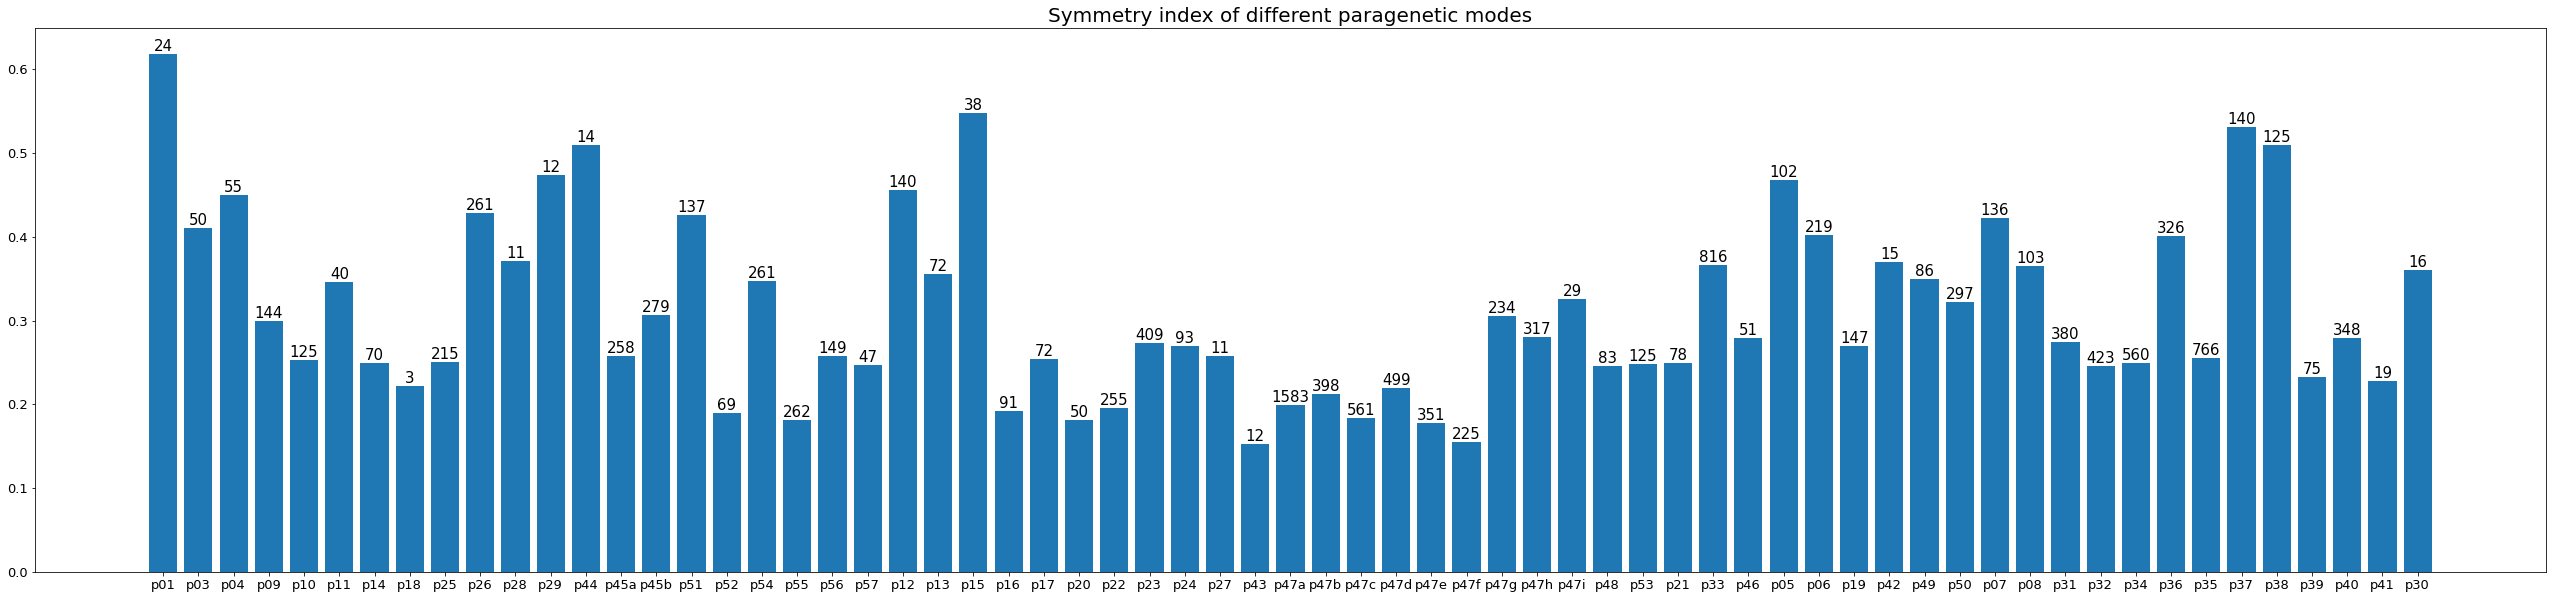

In [46]:
p_max_ordering = sorted(default_ordering, key=lambda p: get_attr(p, P_MAX))
plot_pgm(p_max_ordering, 'graph_pgm_pmax_1', n_plots=1, nums=True)

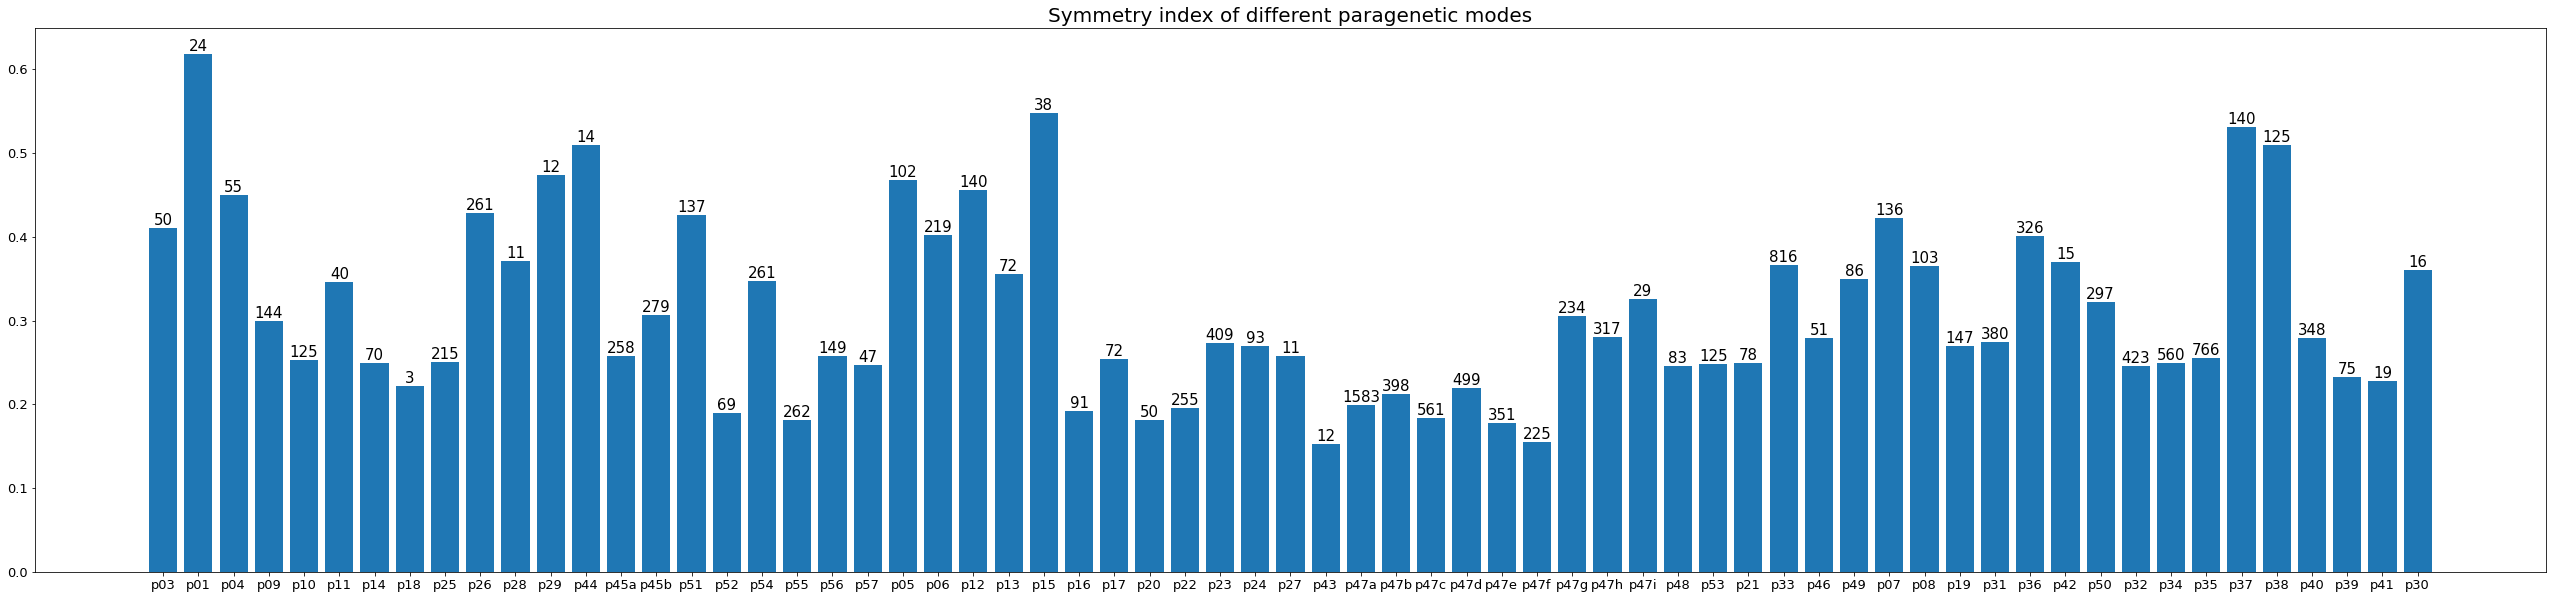

In [47]:
p_avg_ordering = sorted(default_ordering, key=lambda p: get_attr(p, P_AVG))
plot_pgm(p_avg_ordering, 'graph_pgm_pavg_1', n_plots=1, nums=True)

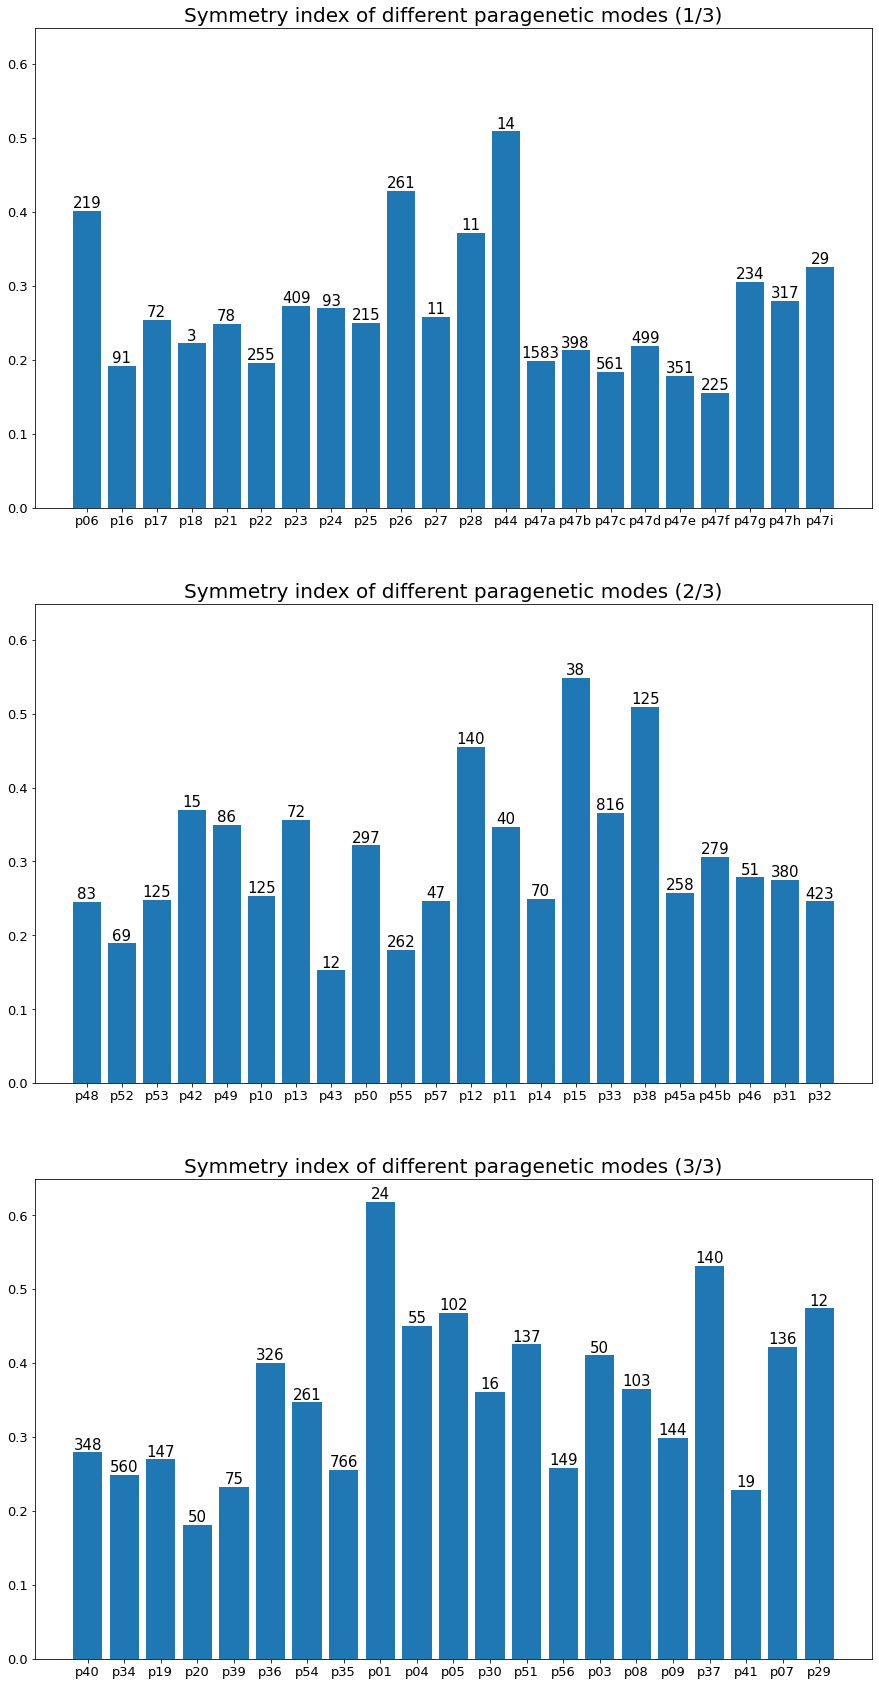

In [48]:
t_min_ordering = sorted(default_ordering, key=lambda p: get_attr(p, T_MIN))
plot_pgm(t_min_ordering, 'graph_pgm_tmin', nums=True)

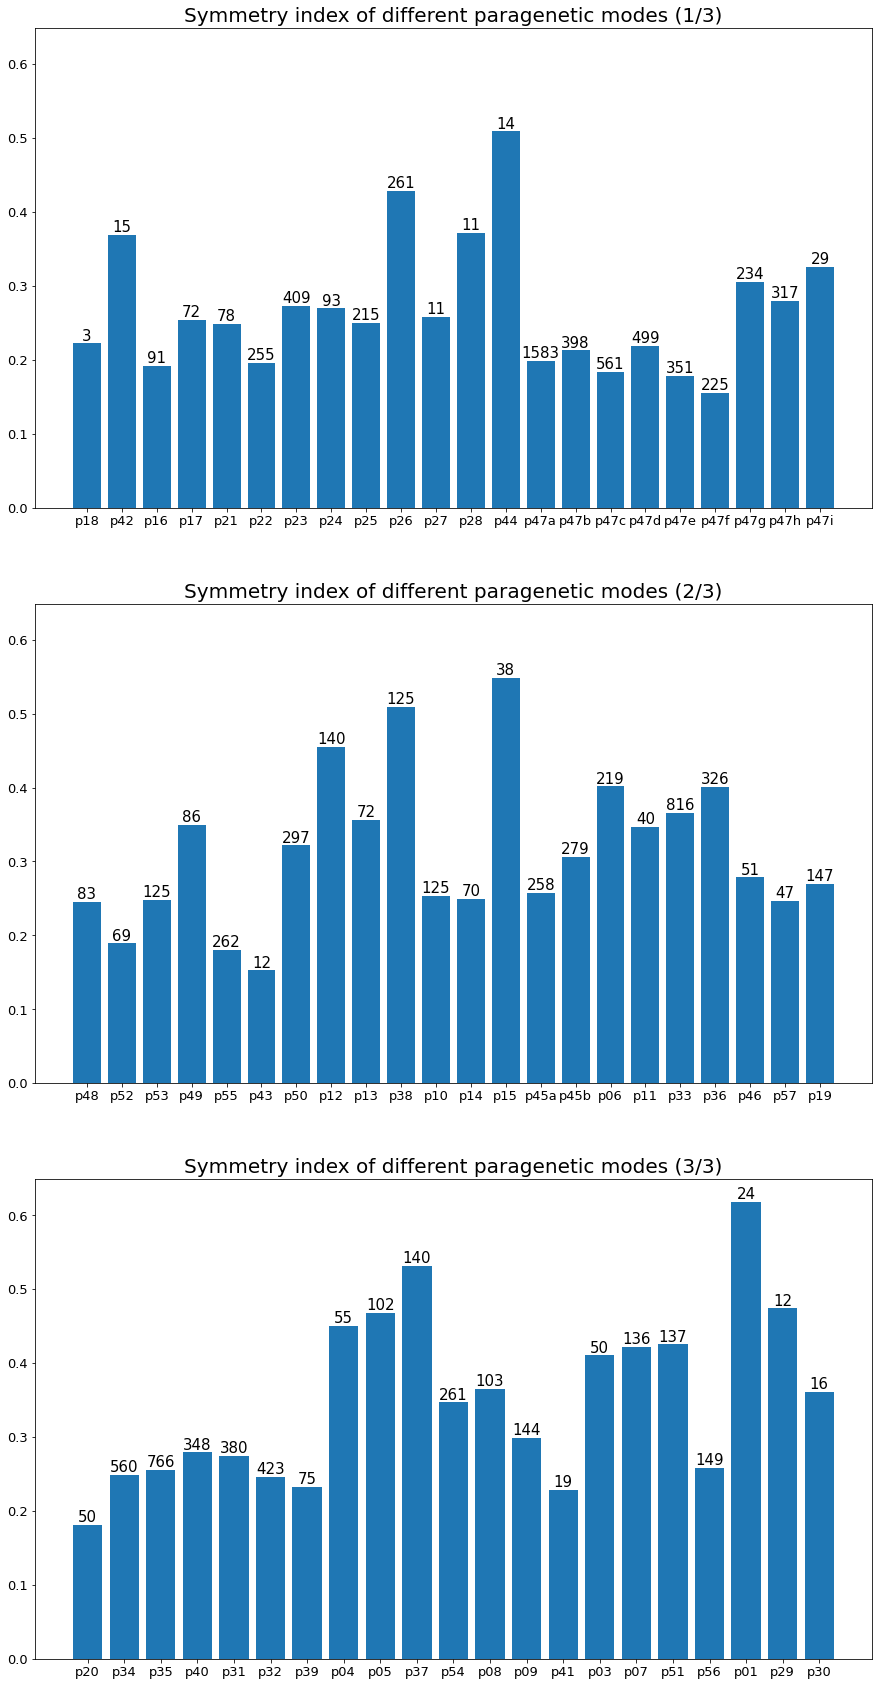

In [49]:
t_max_ordering = sorted(default_ordering, key=lambda p: get_attr(p, T_MAX))
plot_pgm(t_max_ordering, 'graph_pgm_tmax', nums=True)

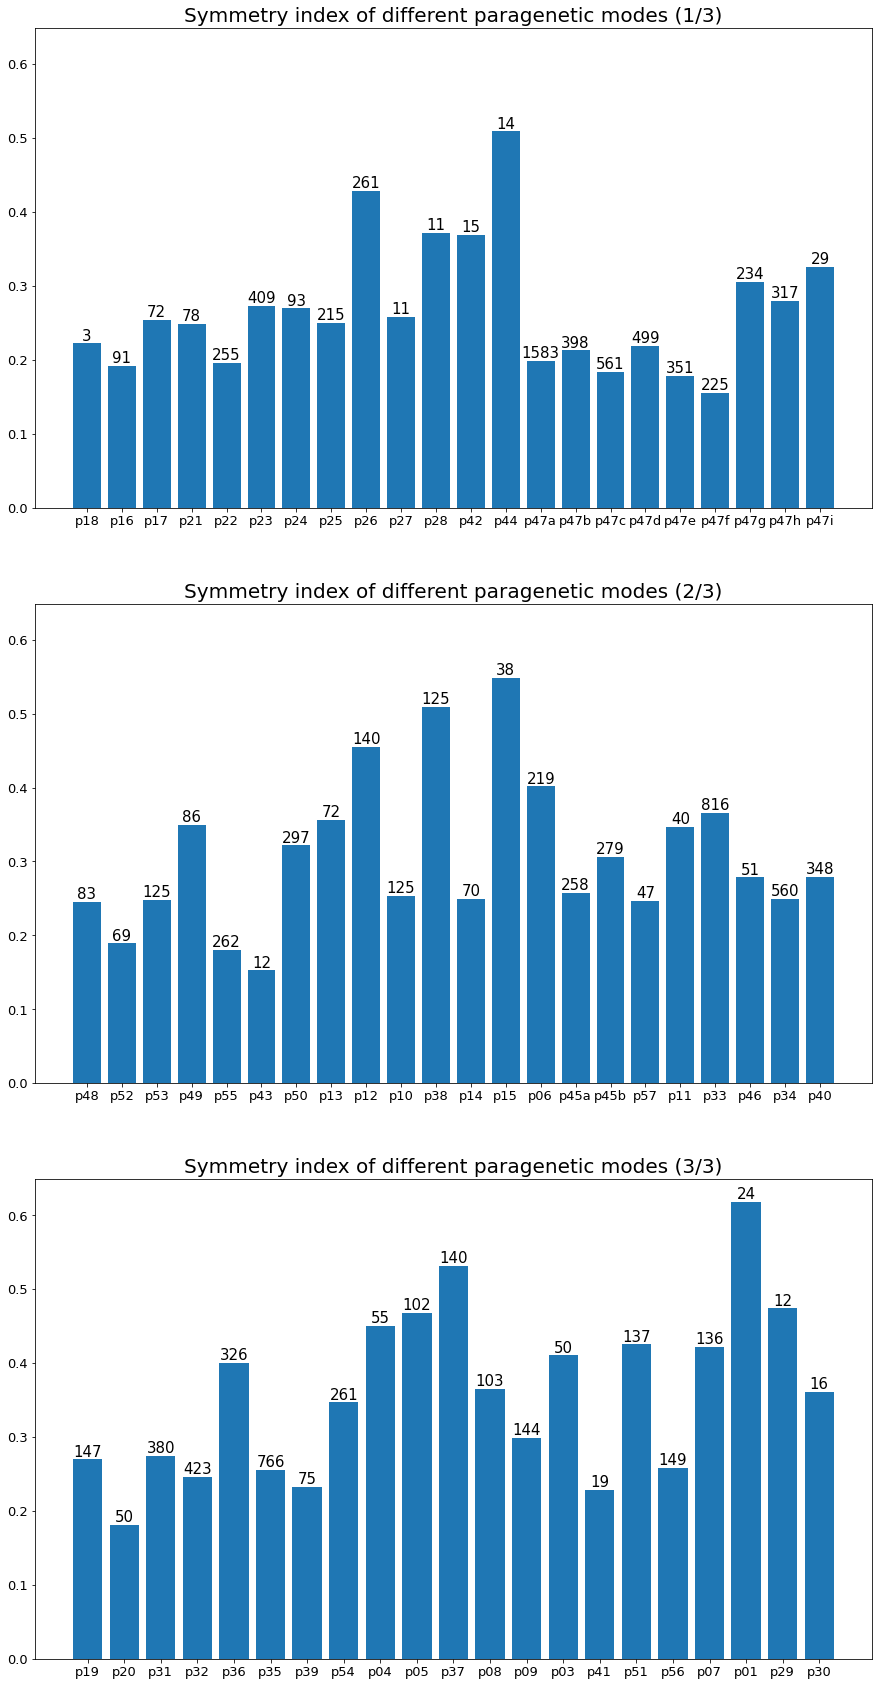

In [50]:
t_avg_ordering = sorted(default_ordering, key=lambda p: get_attr(p, T_AVG))
plot_pgm(t_avg_ordering, 'graph_pgm_tavg', nums=True)

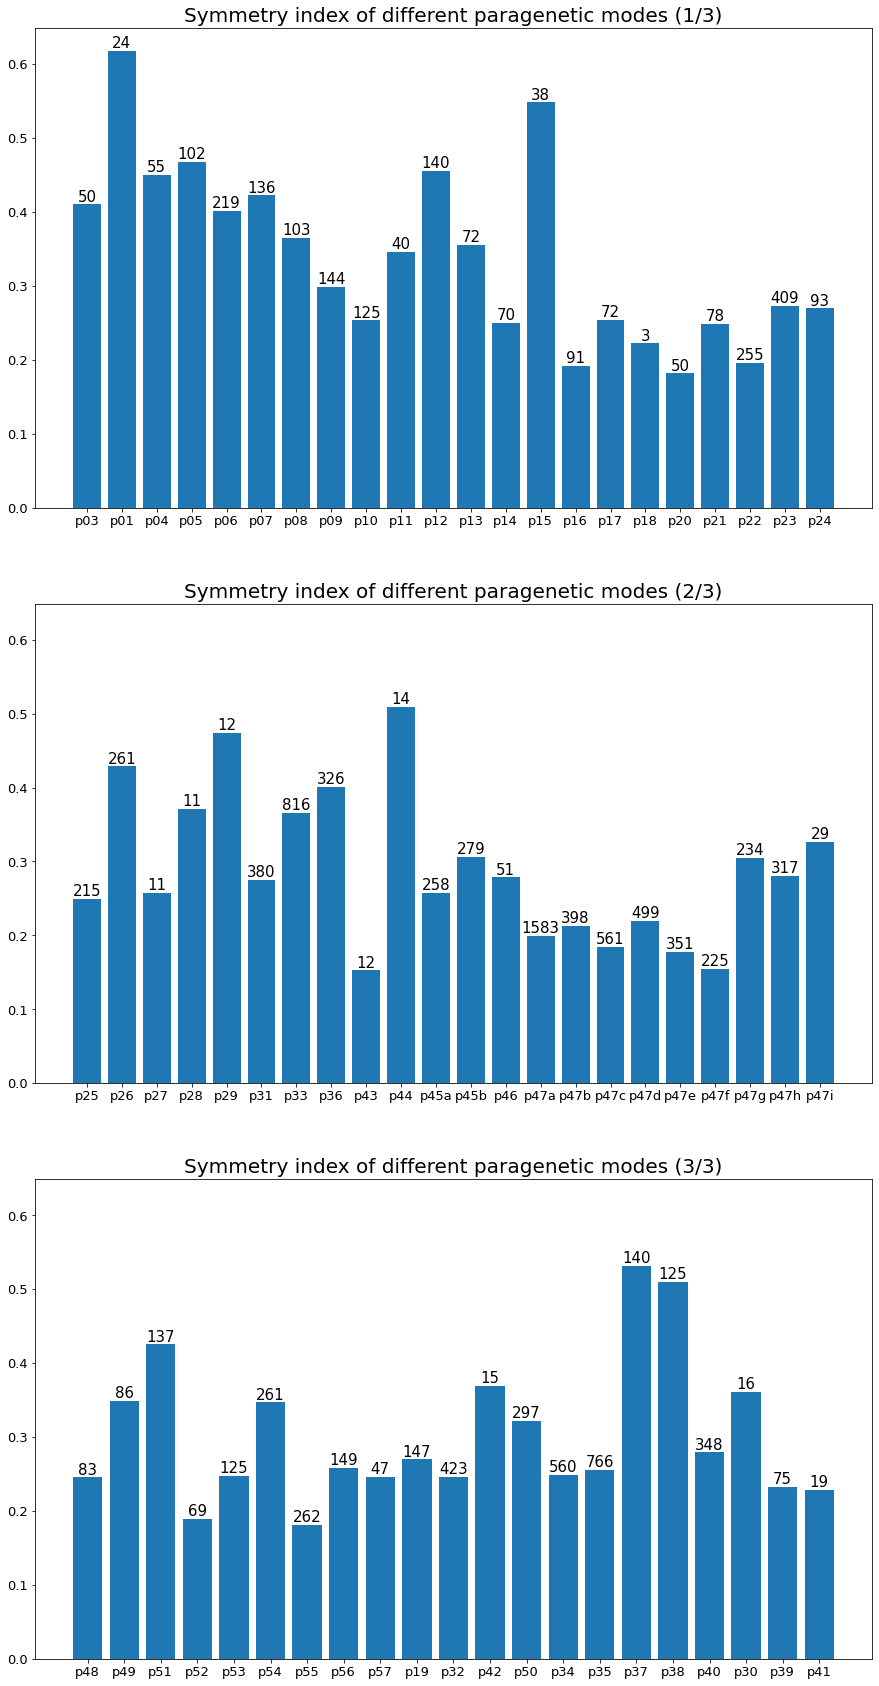

In [51]:
p_min_ordering = sorted(default_ordering, key=lambda p: get_attr(p, P_MIN))
plot_pgm(p_min_ordering, 'graph_pgm_pmin', nums=True)

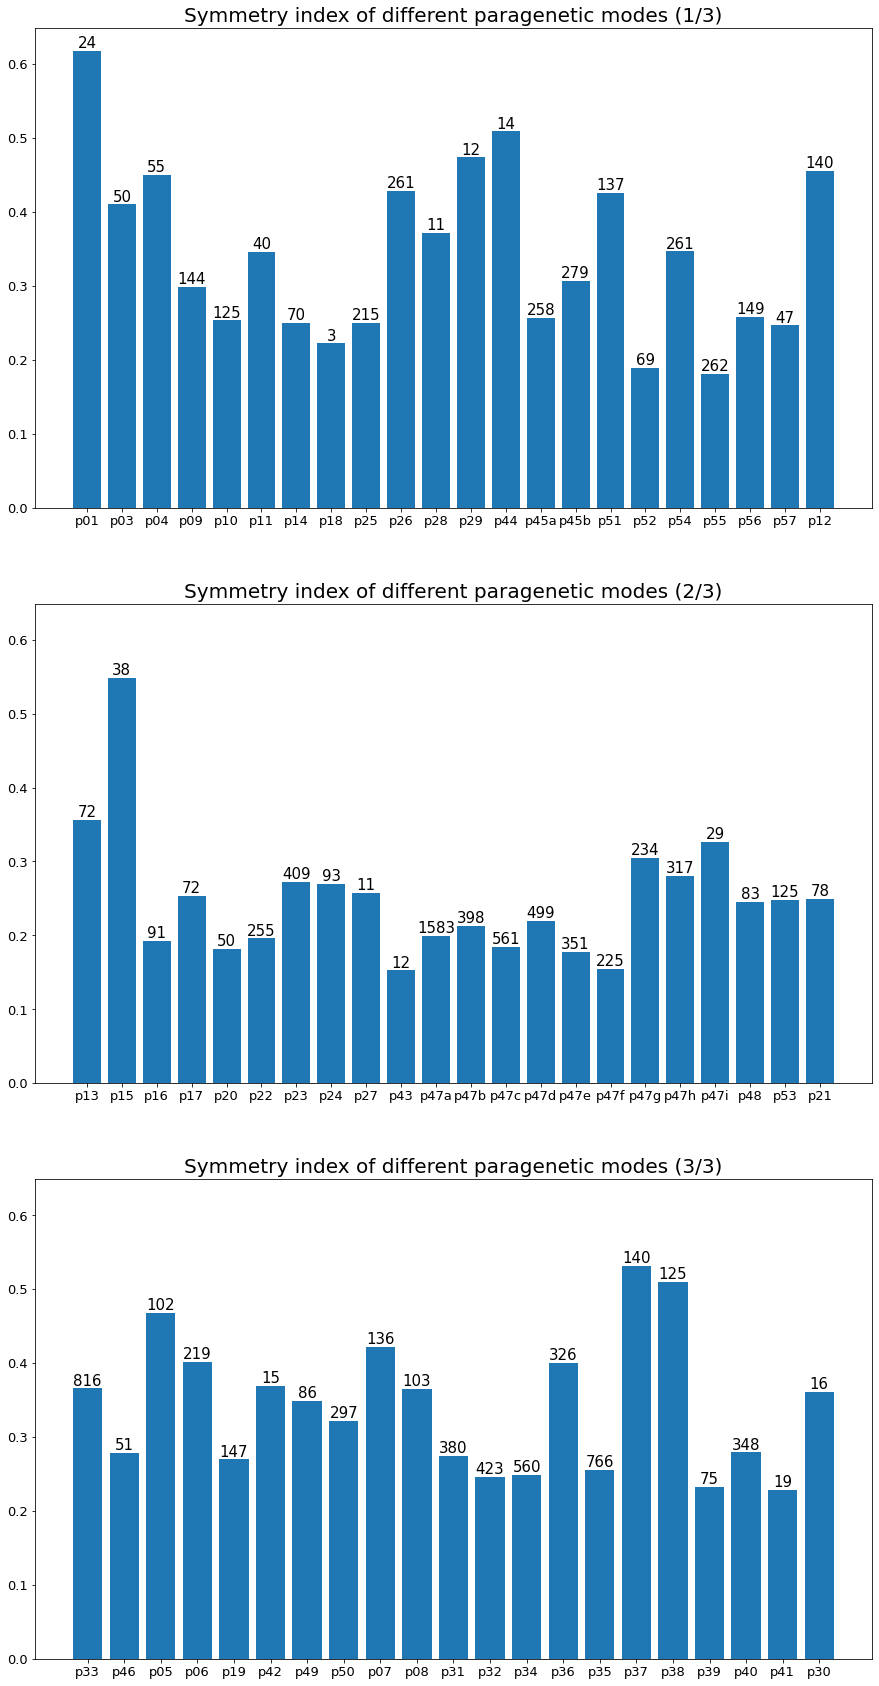

In [52]:
p_max_ordering = sorted(default_ordering, key=lambda p: get_attr(p, P_MAX))
plot_pgm(p_max_ordering, 'graph_pgm_pmax', nums=True)

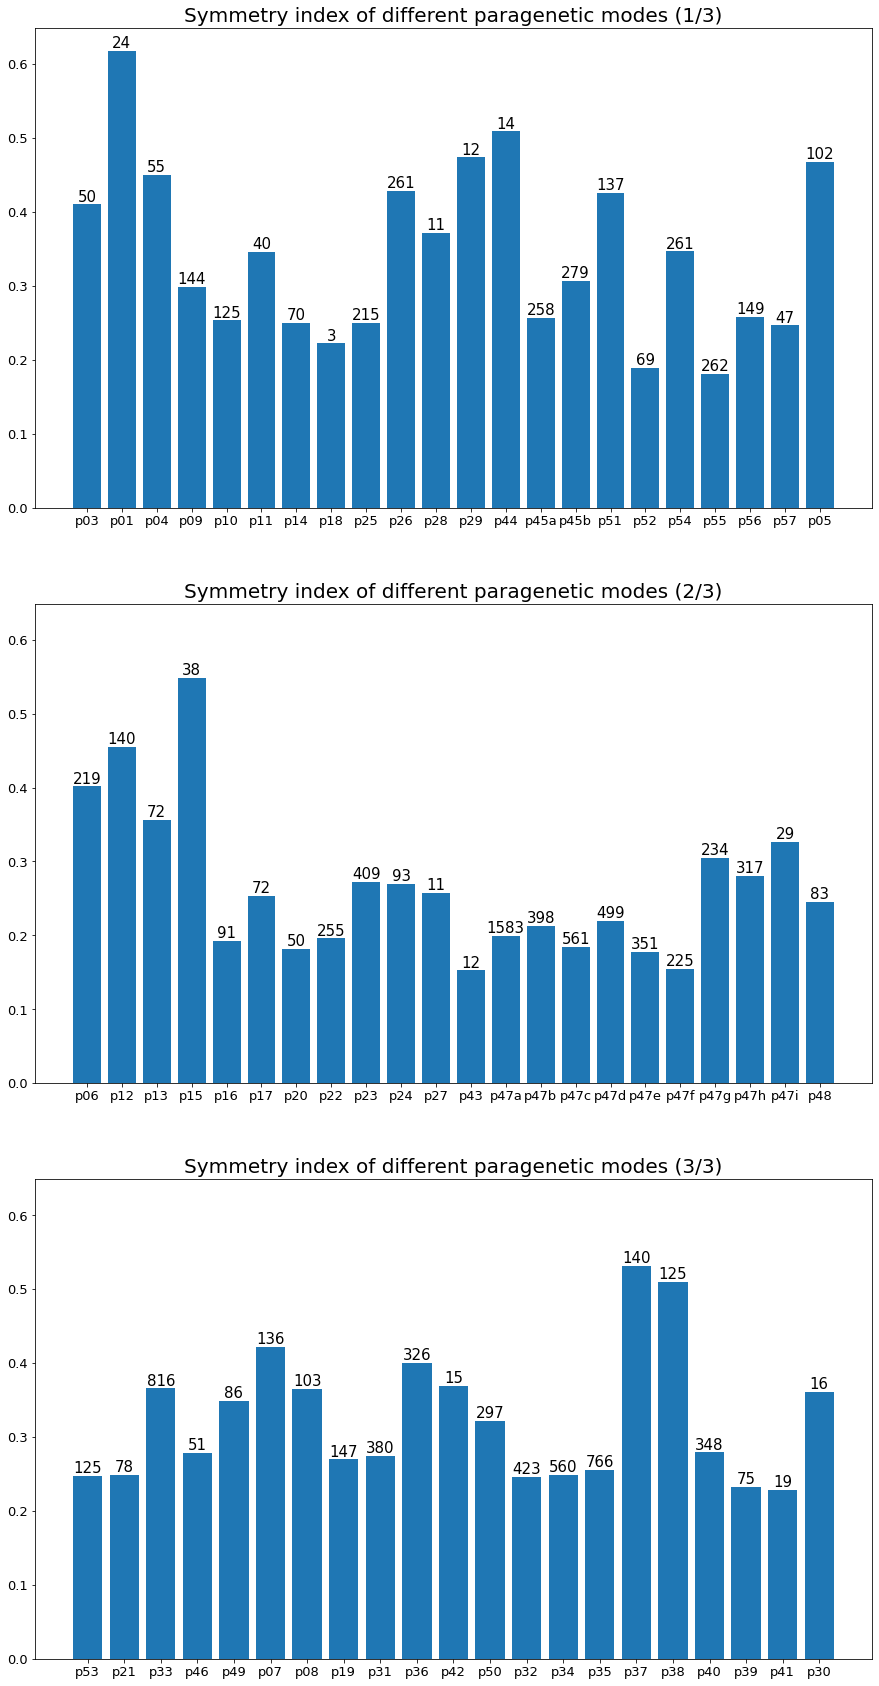

In [53]:
p_avg_ordering = sorted(default_ordering, key=lambda p: get_attr(p, P_AVG))
plot_pgm(p_avg_ordering, 'graph_pgm_pavg', nums=True)

# PT correlations

In [47]:
def minerals_in_crit(CRIT):
    ret = {}
    
    for _, x in rruff_db.iterrows():
        mineral = x['mineral_name']
        
        try:
            pgms = x['pgm']
        except:
            continue

        if pgms is np.nan:
            continue
            

        if len(pgms) == 1:
            if pgms[0] in ['Lunar']:
                continue
                
            c = get_attr(pgms[0], CRIT)
        elif len(pgms) > 1:
            cs = [ get_attr(pgm, CRIT) for pgm in pgms if pgm not in ['Lunar'] ]

            if 'min' in CRIT:
                c = min(cs)
            elif 'max' in CRIT:
                c = max(cs)

        if c in ret.keys():
            ret[c].append(mineral)
        else:
            ret[c] = [ mineral ]
        
    return ret

In [48]:
def sym_ind(CRIT):
    crit_symmetry_indices = {}
    crit_populations = {}
    n_minerals_in_crit = {}
    
    mins_in_crit = minerals_in_crit(CRIT)
    
    for c in mins_in_crit.keys():
        crit_pop = { cs: 0 for cs in symmetry_indices.keys() }
        num_minerals = 0
        crit_sym_ind = 0

        for _, x in rruff_db[rruff_db['mineral_name'].isin(mins_in_crit[c])].iterrows():
            try:
                cn = df[df.name == x['mineral_name']]['Class Nbr.'].to_numpy()[0]
            except:
                continue
    
            if cn == 0 or cn > 32:
                continue
                        
            crit_pop[cn] += 1
            num_minerals += 1
            crit_sym_ind += symmetry_indices[cn]
                    
        try:
            crit_symmetry_indices[c] = crit_sym_ind / max(symmetry_indices.values()) / num_minerals
        except Exception as e:
            print(e)

        crit_populations[c] = crit_pop
        n_minerals_in_crit[c] = num_minerals

    crit_symmetry_indices = { crit: crit_symmetry_indices[crit] for crit in sorted(crit_symmetry_indices) }
    
    return crit_symmetry_indices, n_minerals_in_crit, crit_populations

In [49]:
crit_symmetry_indices, n_minerals_in_crit, crit_avg_populations = {}, {}, {}

for CRIT in [ T_MIN, T_MAX, P_MIN, P_MAX ]:
    crit_symmetry_indices[CRIT], n_minerals_in_crit[CRIT], crit_avg_populations[CRIT] = sym_ind(CRIT)

In [50]:
def plot_crit(CRIT, name, n_plots=1, nums=False):
    fig, ax = plt.subplots(n_plots, figsize=(15, 10*n_plots))
    ordering = list(crit_symmetry_indices[CRIT].keys())
    l = len(ordering)//n_plots
    
    if n_plots == 1:
        ax = [ax]
    
    if len(ordering) % n_plots != 0:
        l += 1

    for i in range(n_plots):
        s, e = i*l, (i+1)*l
        
        num_name = f' ({(i+1)}/{n_plots})' if n_plots > 1 else ''
        crit_name = " ".join(CRIT.split()[:2])

        r = len(ordering[s:e])
        bars = ax[i].bar(range(r), [ crit_symmetry_indices[CRIT][p] for p in ordering[s:e] ])
        ax[i].set_xticks(range(r), labels=ordering[s:e])
        ax[i].tick_params(axis='both', labelsize=FS_TICK)
        ax[i].set_title(f'Symmetry index by {crit_name}{num_name}', fontsize=FS_TITLE)
        plt.xlabel(CRIT, fontsize=20)

    # [ print(f'{p}:\t {sym:.3f}') for p, sym in pgm_symmetry_indices.items() ]

        if nums:
            for n_minerals, bar in zip([ n_minerals_in_crit[CRIT][p] for p in ordering[s:e] ], bars):
                ax[i].text(bar.get_x() + bar.get_width()/2, bar.get_height(),
                           f'{n_minerals}',
                           ha='center', va='bottom', fontsize=FS_SAMPLE
                          )

    plt.savefig(f'results/{name}.png')

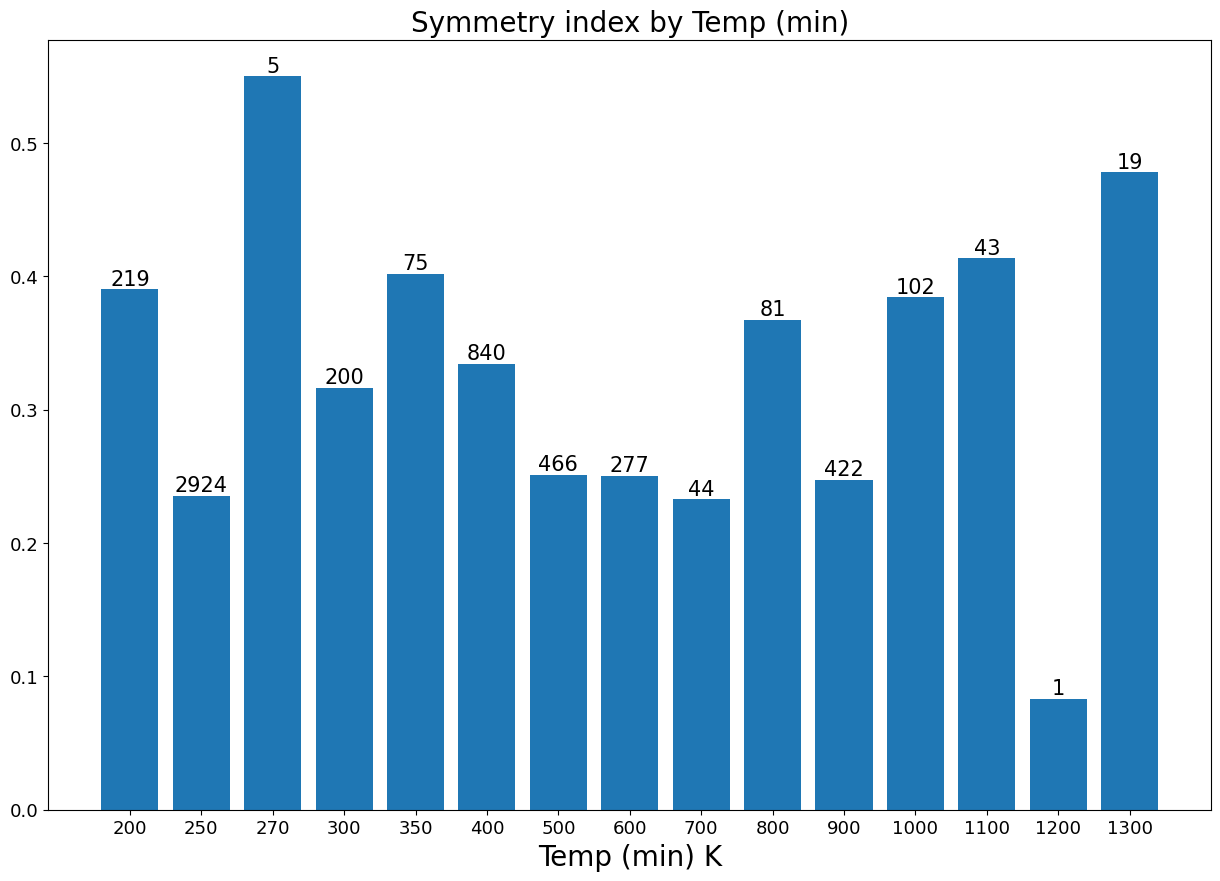

In [41]:
plot_crit(T_MIN, 'graph_tmin', nums=True)

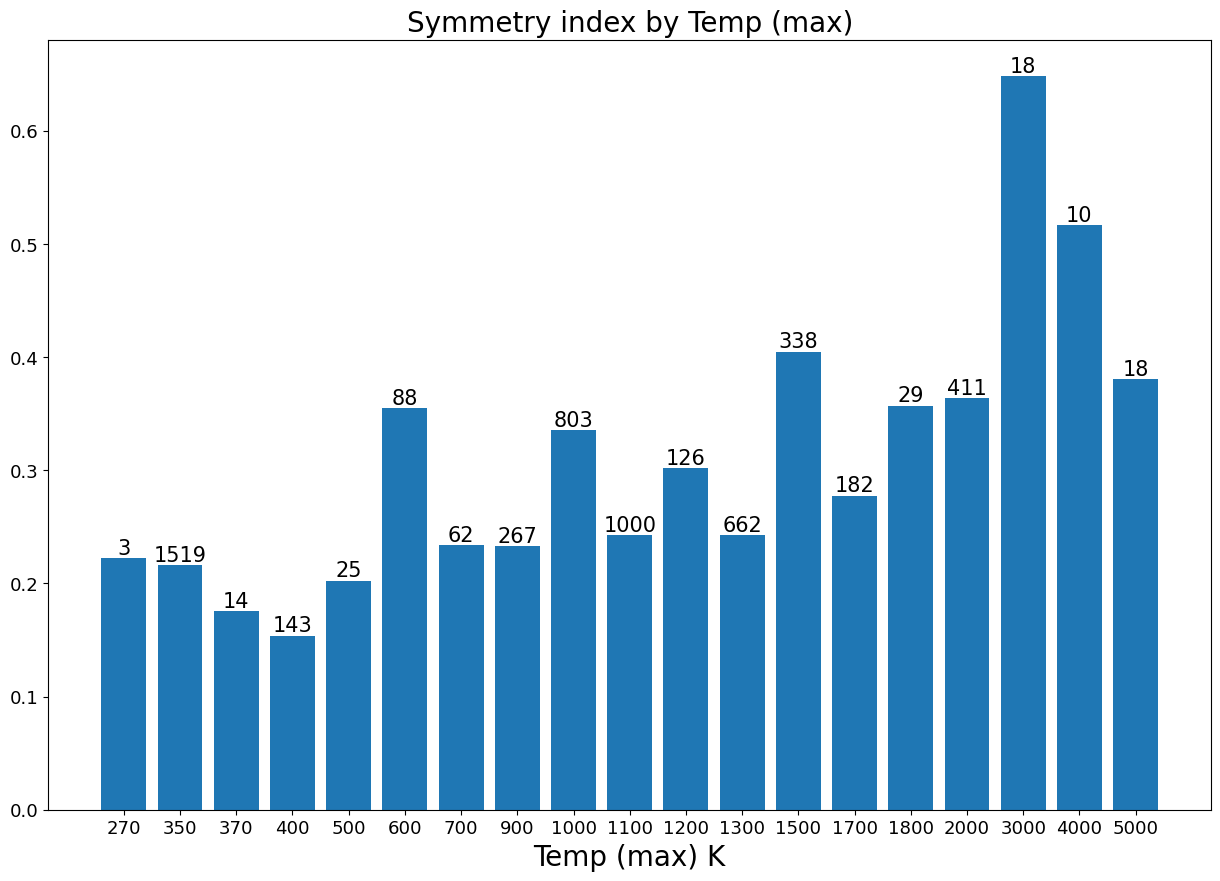

In [42]:
plot_crit(T_MAX, 'graph_tmax', nums=True)

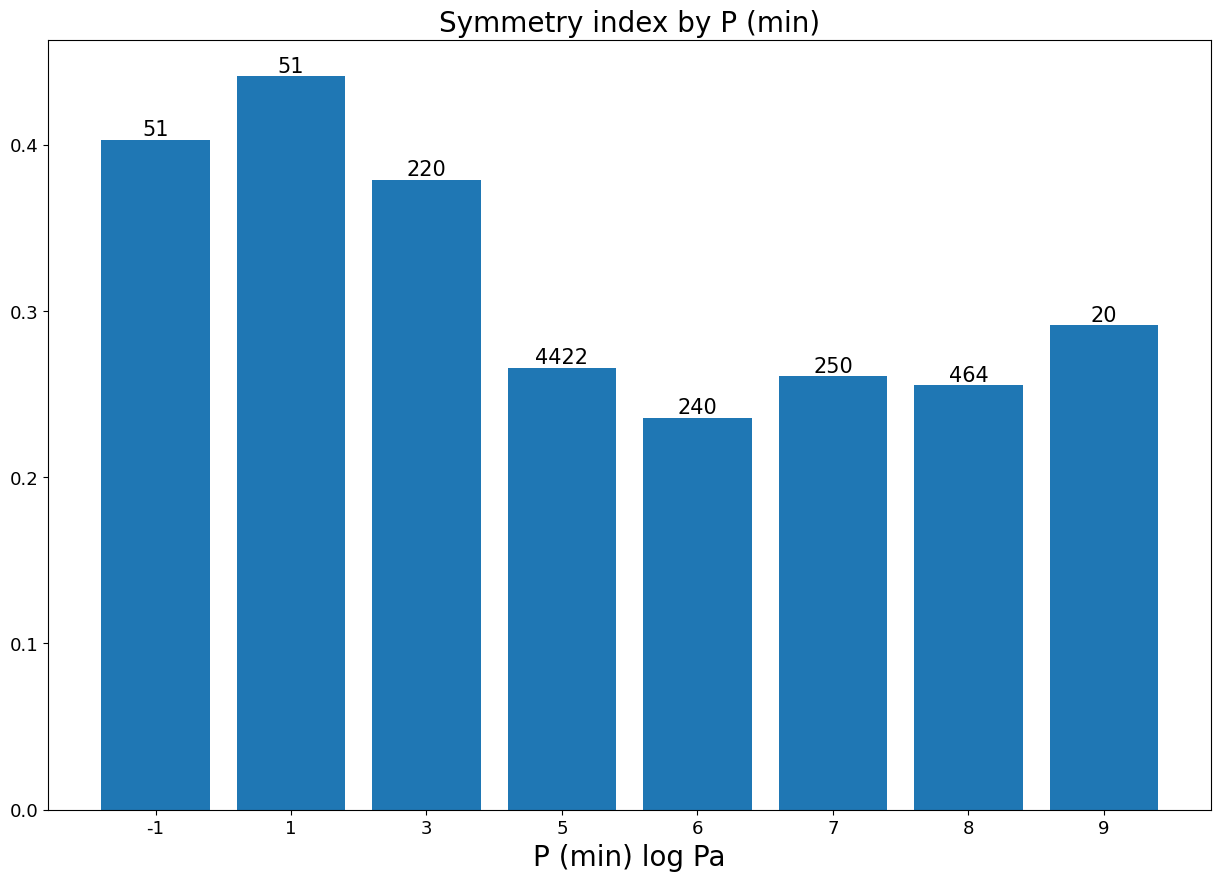

In [43]:
plot_crit(P_MIN, 'graph_pmin', nums=True)

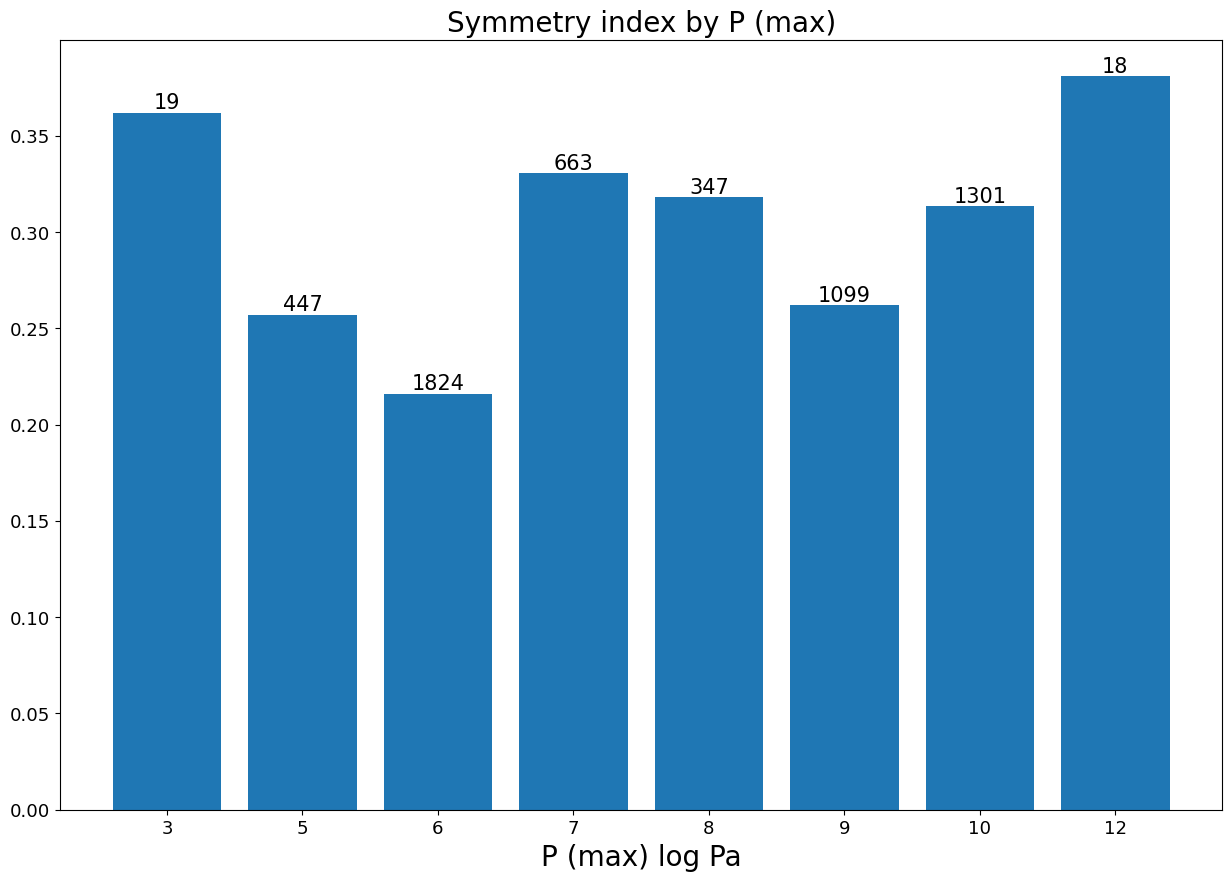

In [44]:
plot_crit(P_MAX, 'graph_pmax', nums=True)

In [53]:
def scatter_crit(CRIT, name, fit_q=False, start=None, end=None):
    if type(end) == int:
        end = -end
    
    plt.figure(figsize=(15, 10))
    ordering = list(crit_symmetry_indices[CRIT].keys())[start:end]
    syms = [ crit_symmetry_indices[CRIT][p] for p in ordering ]
    l = len(ordering)

    crit_name = " ".join(CRIT.split()[:2])
    if start is not None or end is not None:
        str_start = str(start) if start is not None else ''
        str_end = str(end) if end is not None else ''
        
        name += f'_exc_[{str_start}:{str_end}]'
    
    x_values = np.array(ordering)
    y_values = np.array(syms)
    
    # Calculate Pearson correlation coefficient
    correlation_coefficient, p_value = pearsonr(x_values, y_values)
    
    # Create the scatter plot
    plt.figure(figsize=(8, 6))  # Adjust the figure size if needed
    plt.scatter(x_values, y_values, color='blue', alpha=0.8, label='Data')  # Adjust color and transparency as needed
    
    # Plot the best fit line
    m, b = np.polyfit(x_values, y_values, 1)
    plt.plot(x_values, m*x_values + b, color='red', alpha=0.7, label=f'Best Fit Line (Correlation: {correlation_coefficient:.2f})')
    plt.xlabel(CRIT, fontsize=16)
    plt.ylabel('Symmetry Index', fontsize=16)
    plt.grid(True, alpha=0.2)  # Add gridlines if needed
    plt.legend()
    
    # Adjust the font size for the numbers on the x and y axes
    plt.tick_params(axis='both', which='major', labelsize=12)
    
    plt.savefig(f'results/{name}.png', dpi=300)
    plt.show()

<Figure size 1500x1000 with 0 Axes>

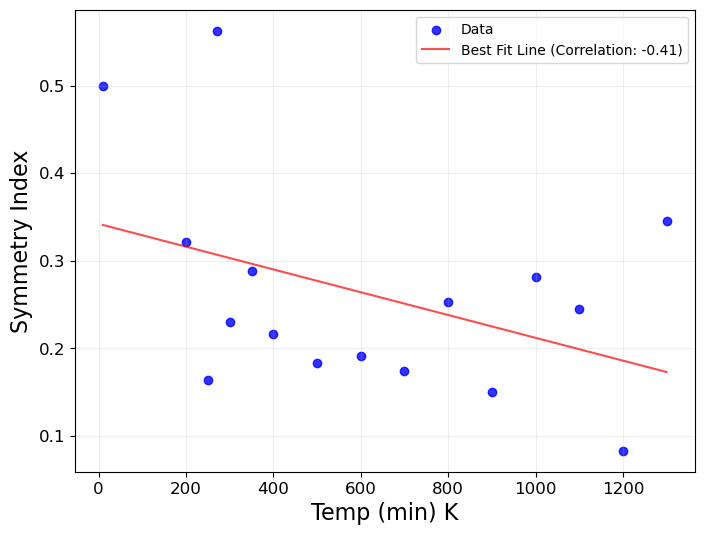

In [55]:
scatter_crit(T_MIN, 'graph_scatter_tmin')

<Figure size 1500x1000 with 0 Axes>

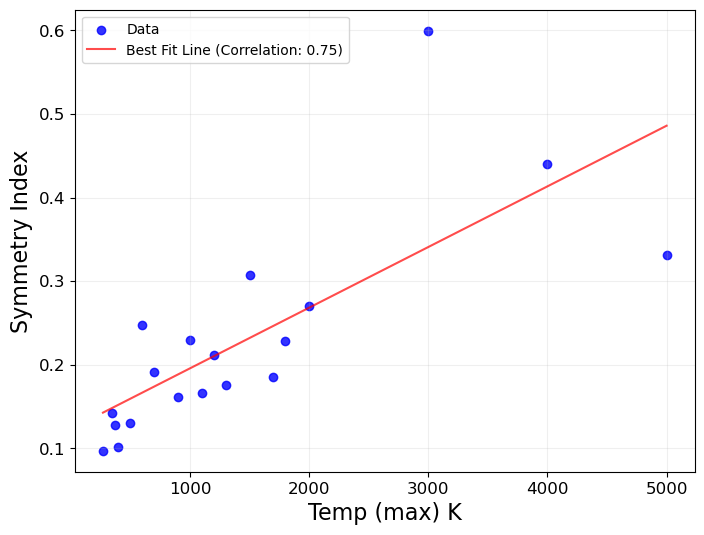

In [56]:
scatter_crit(T_MAX, 'graph_scatter_tmax')

<Figure size 1500x1000 with 0 Axes>

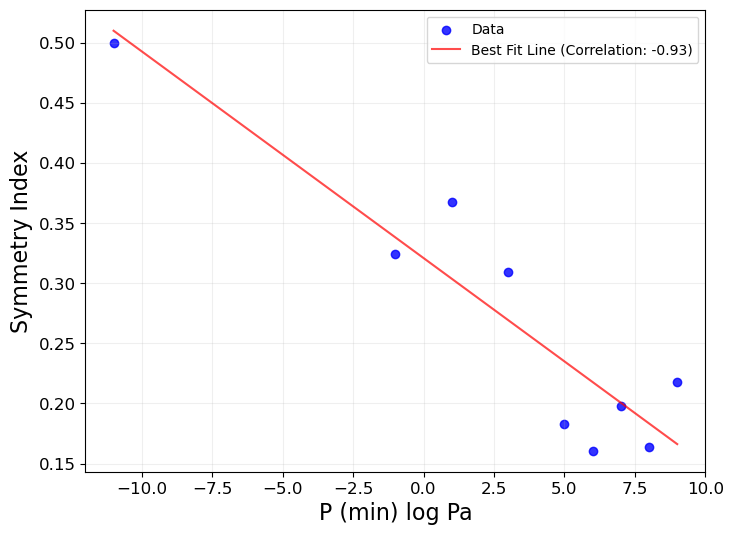

In [57]:
scatter_crit(P_MIN, 'graph_scatter_pmin')

<Figure size 1500x1000 with 0 Axes>

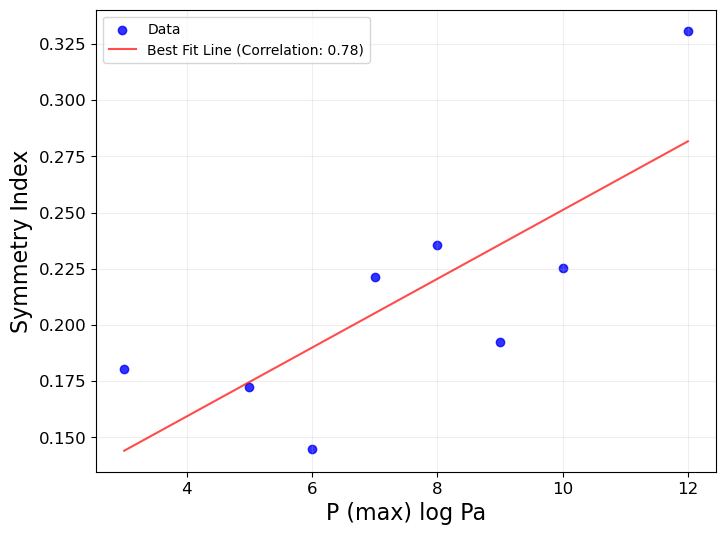

In [60]:
scatter_crit(P_MAX, 'graph_scatter_pmax')